In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

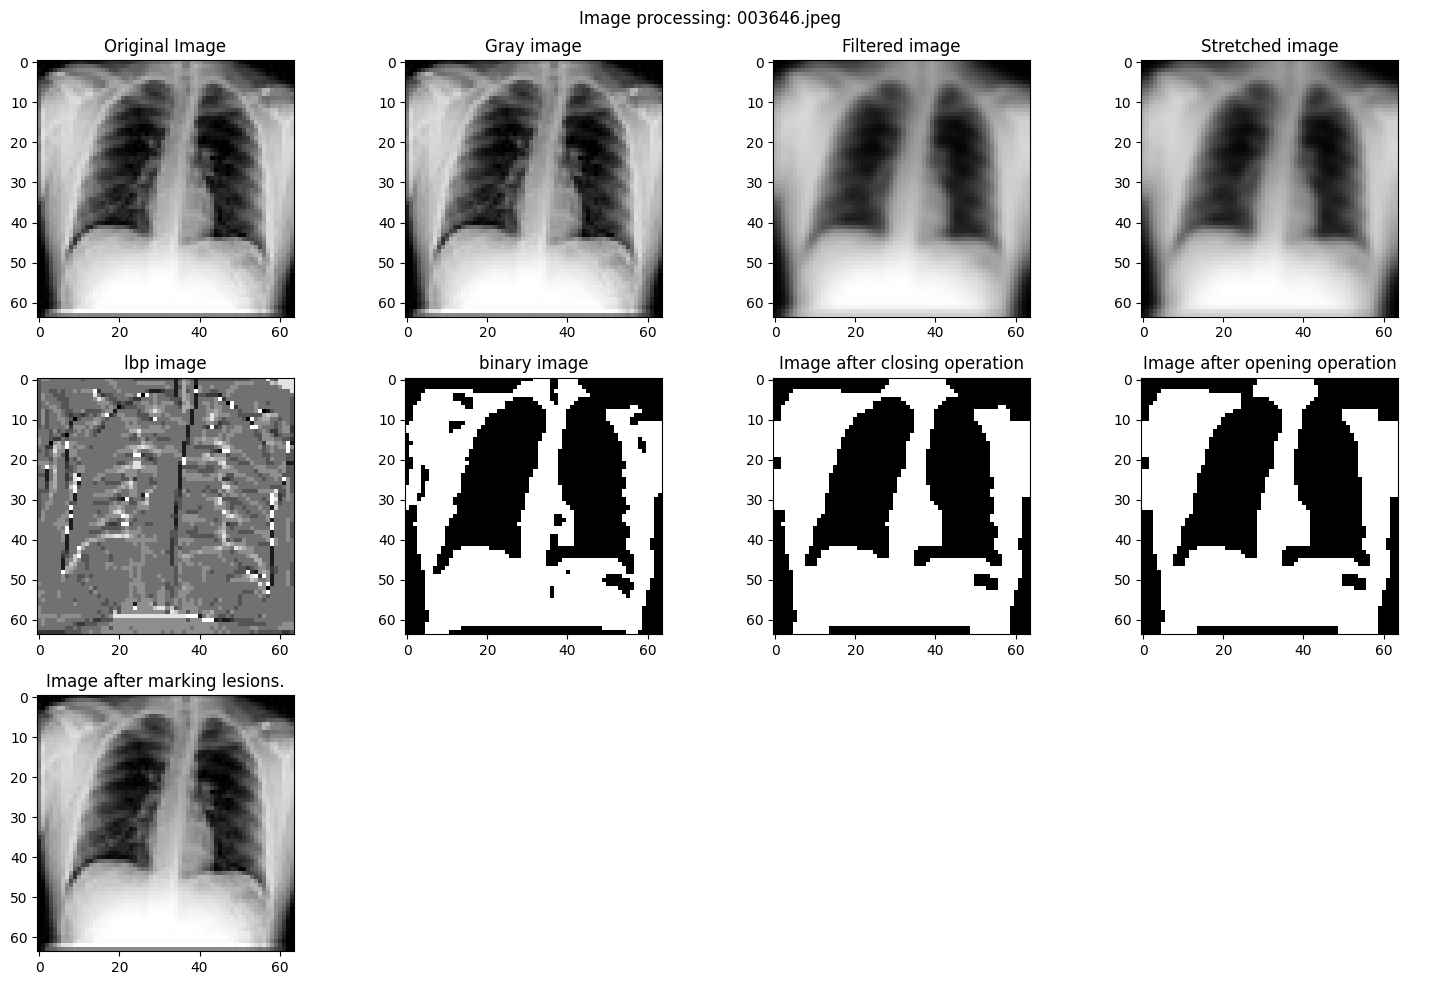

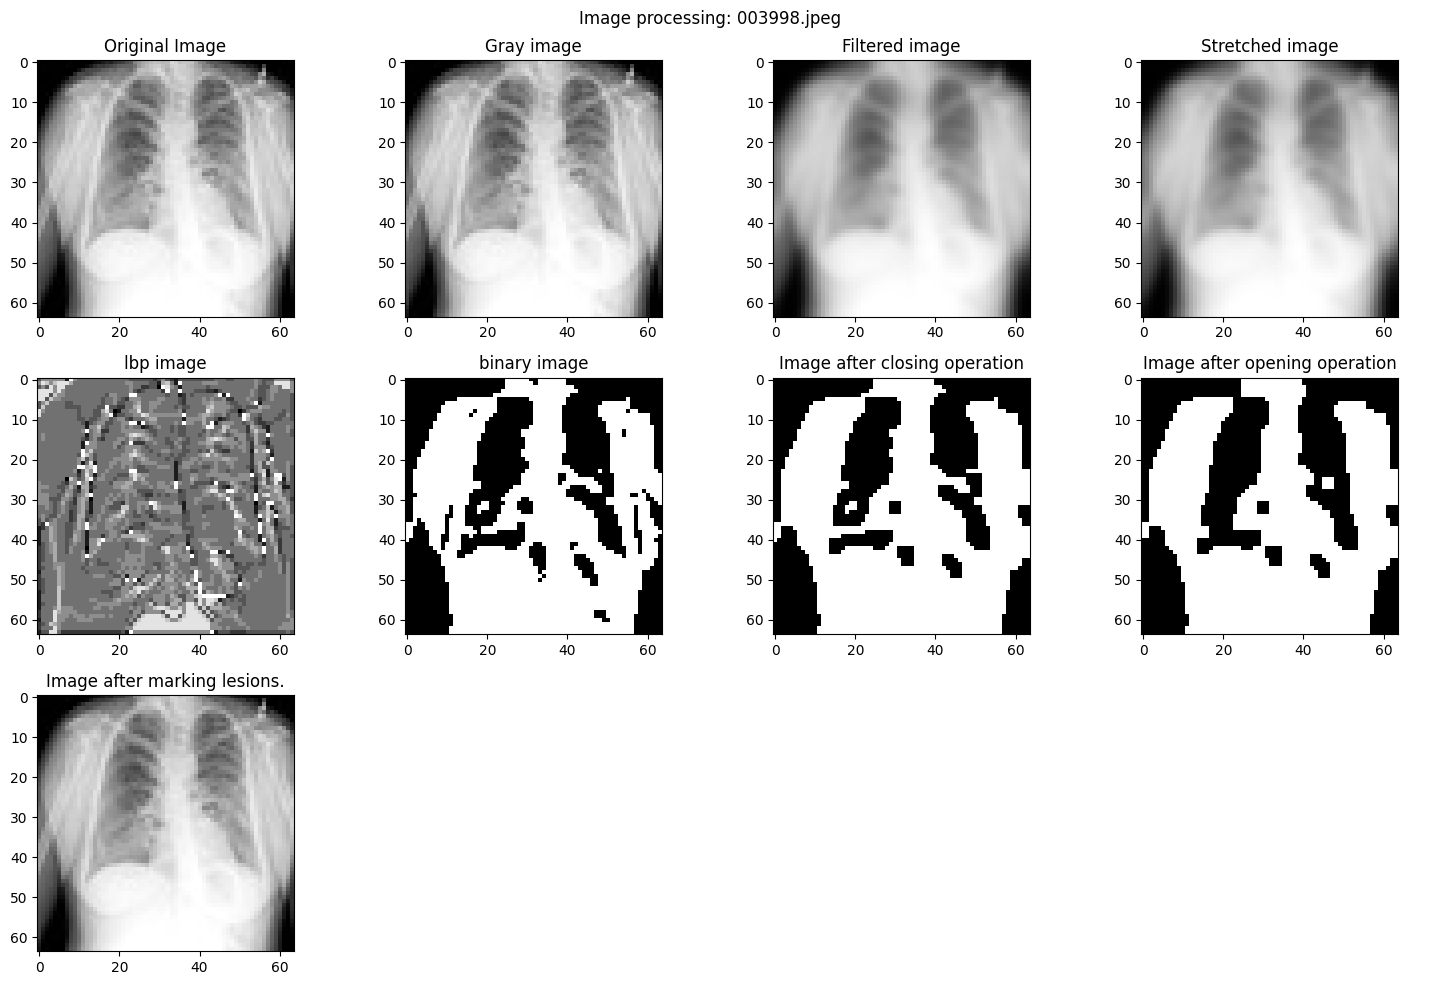

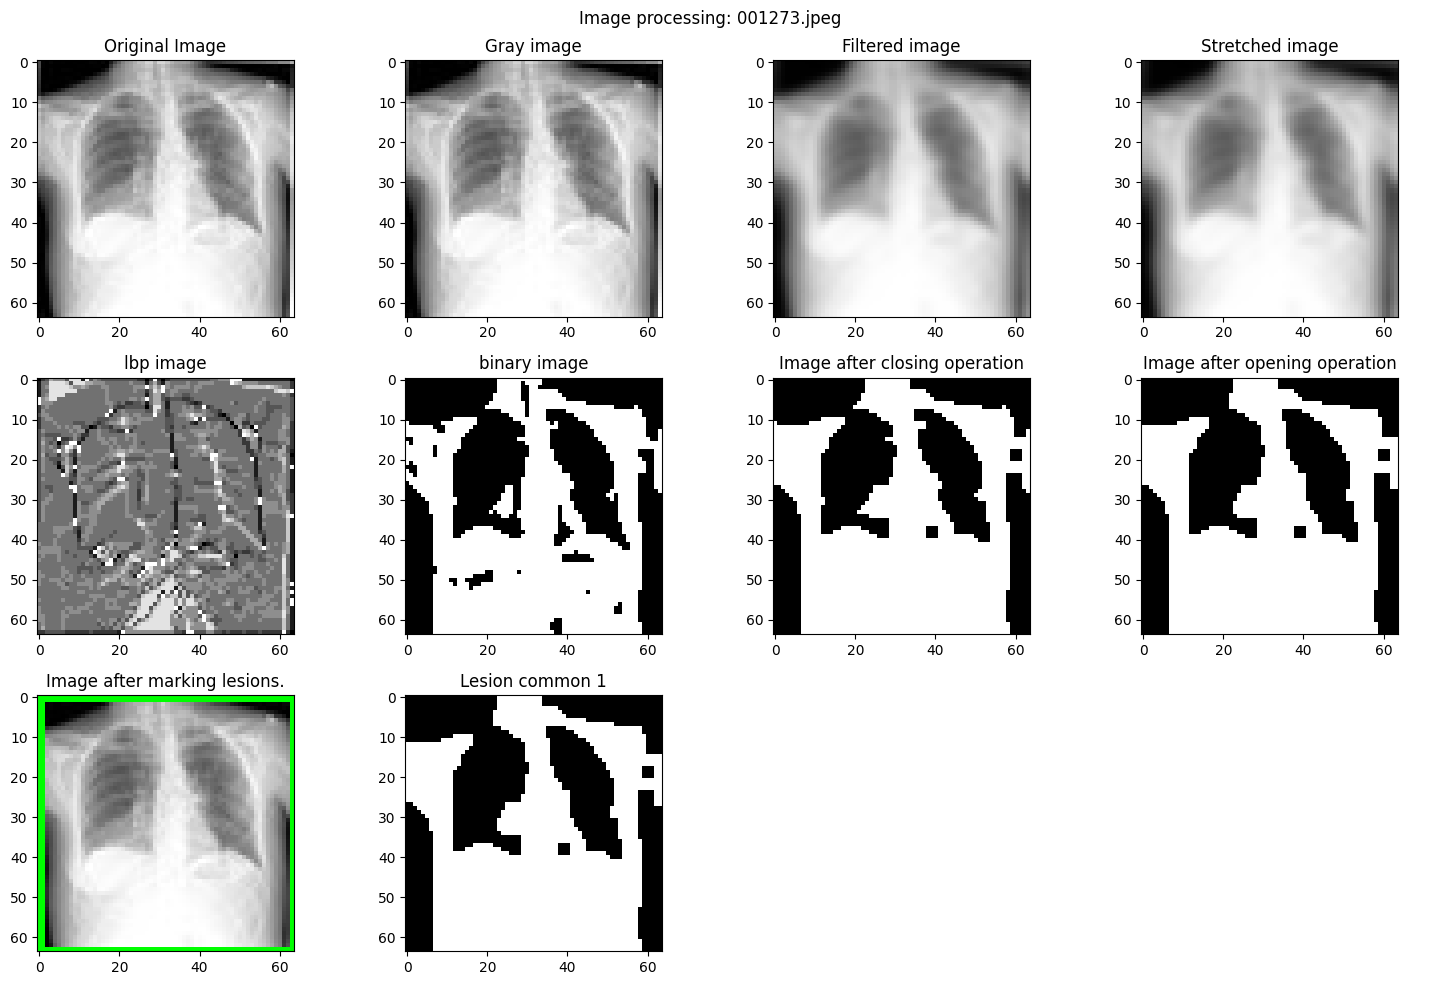

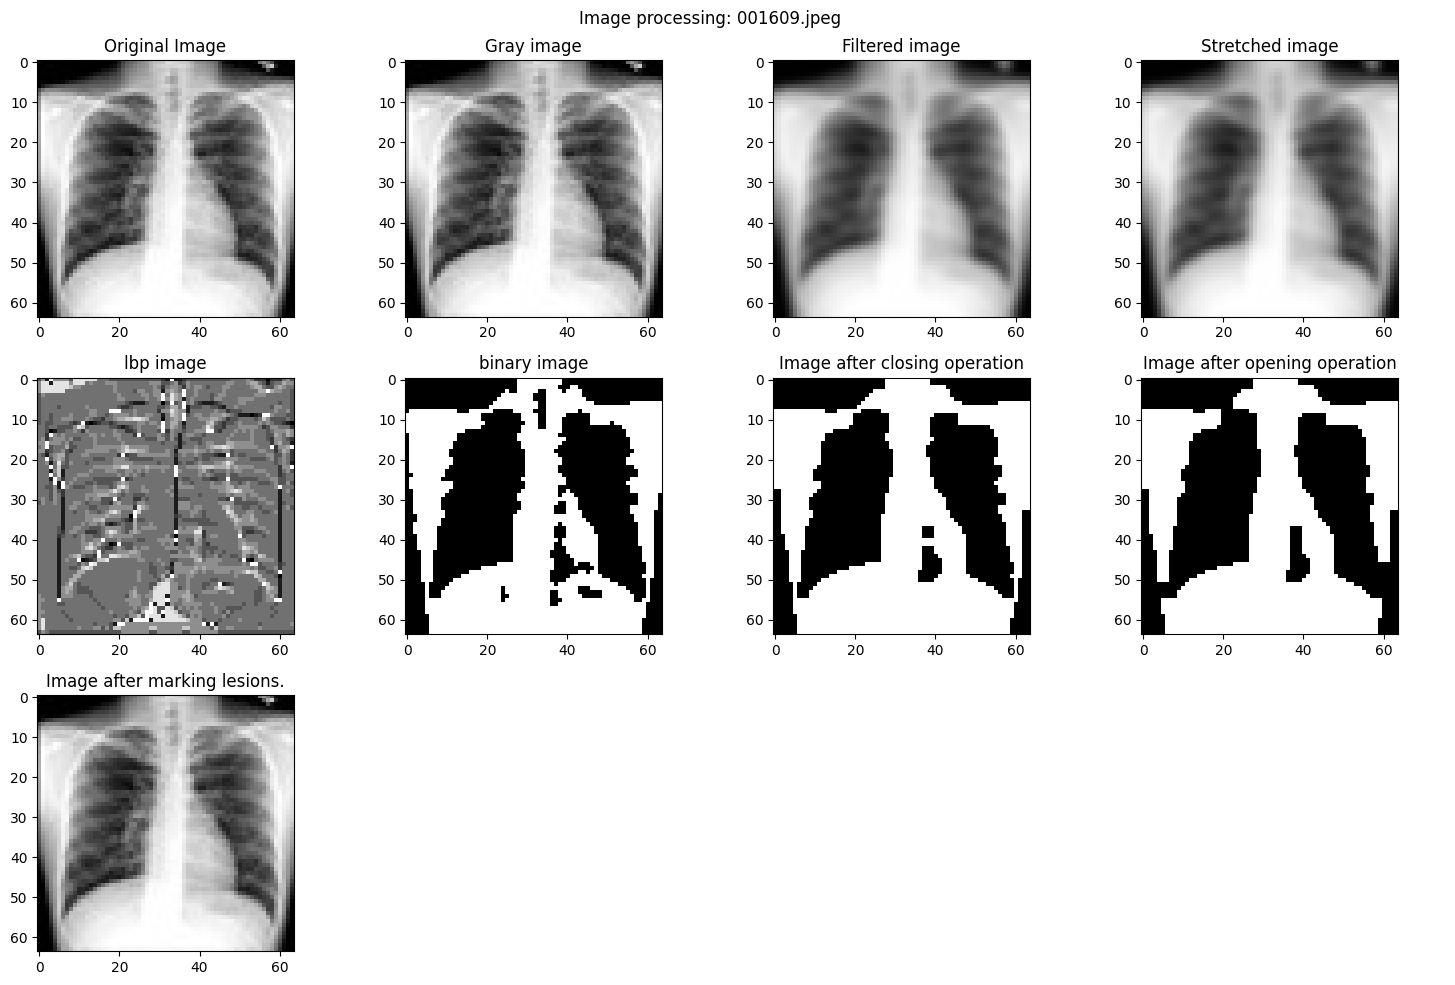

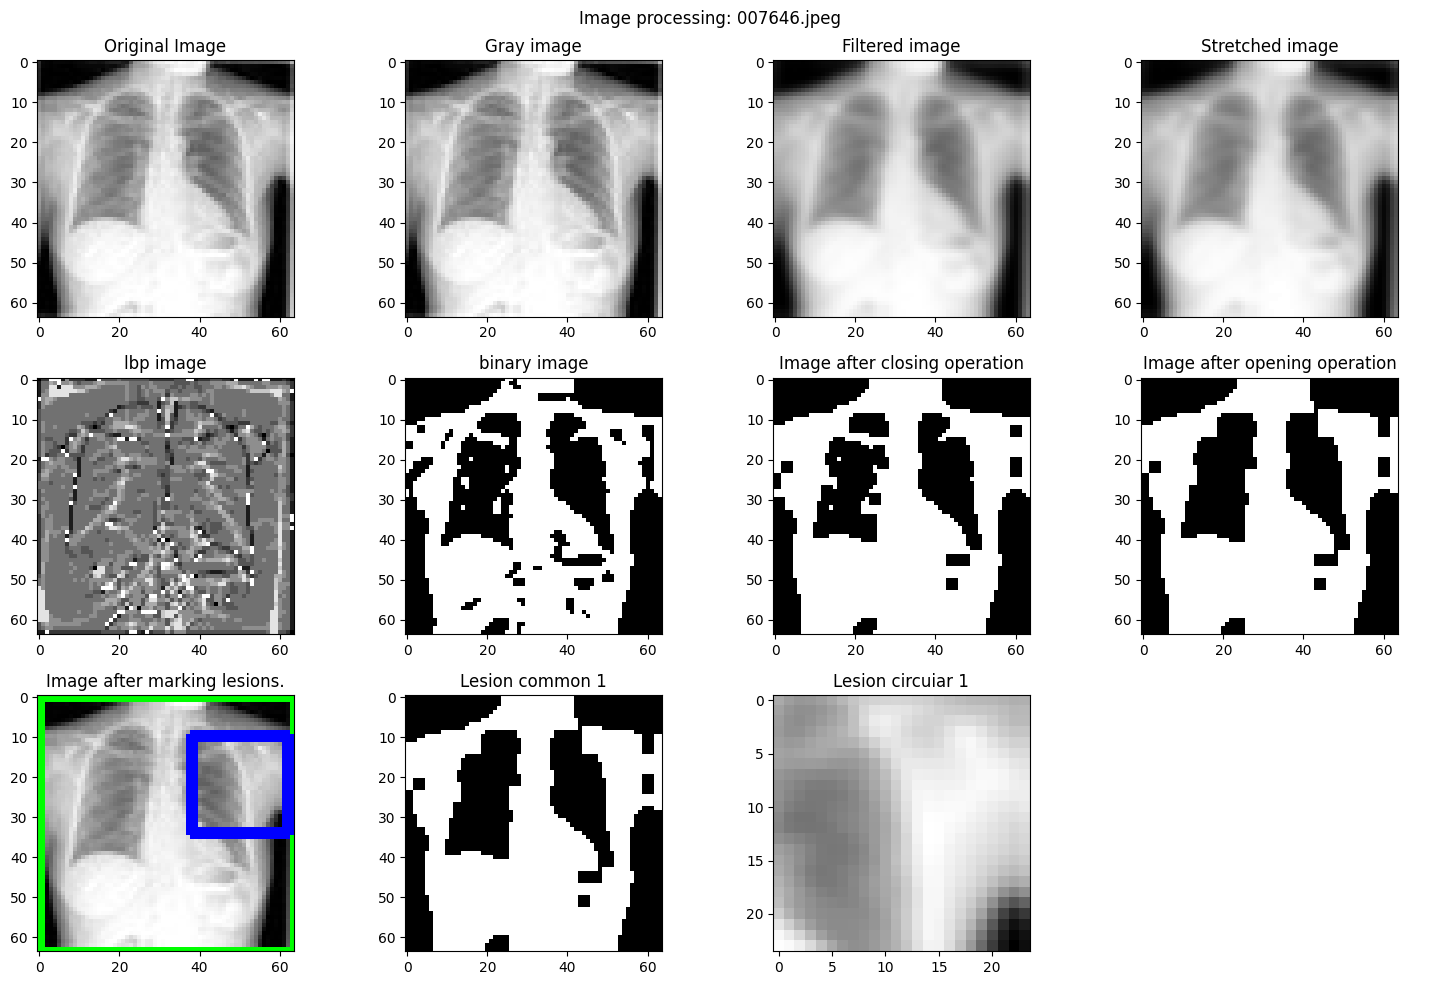

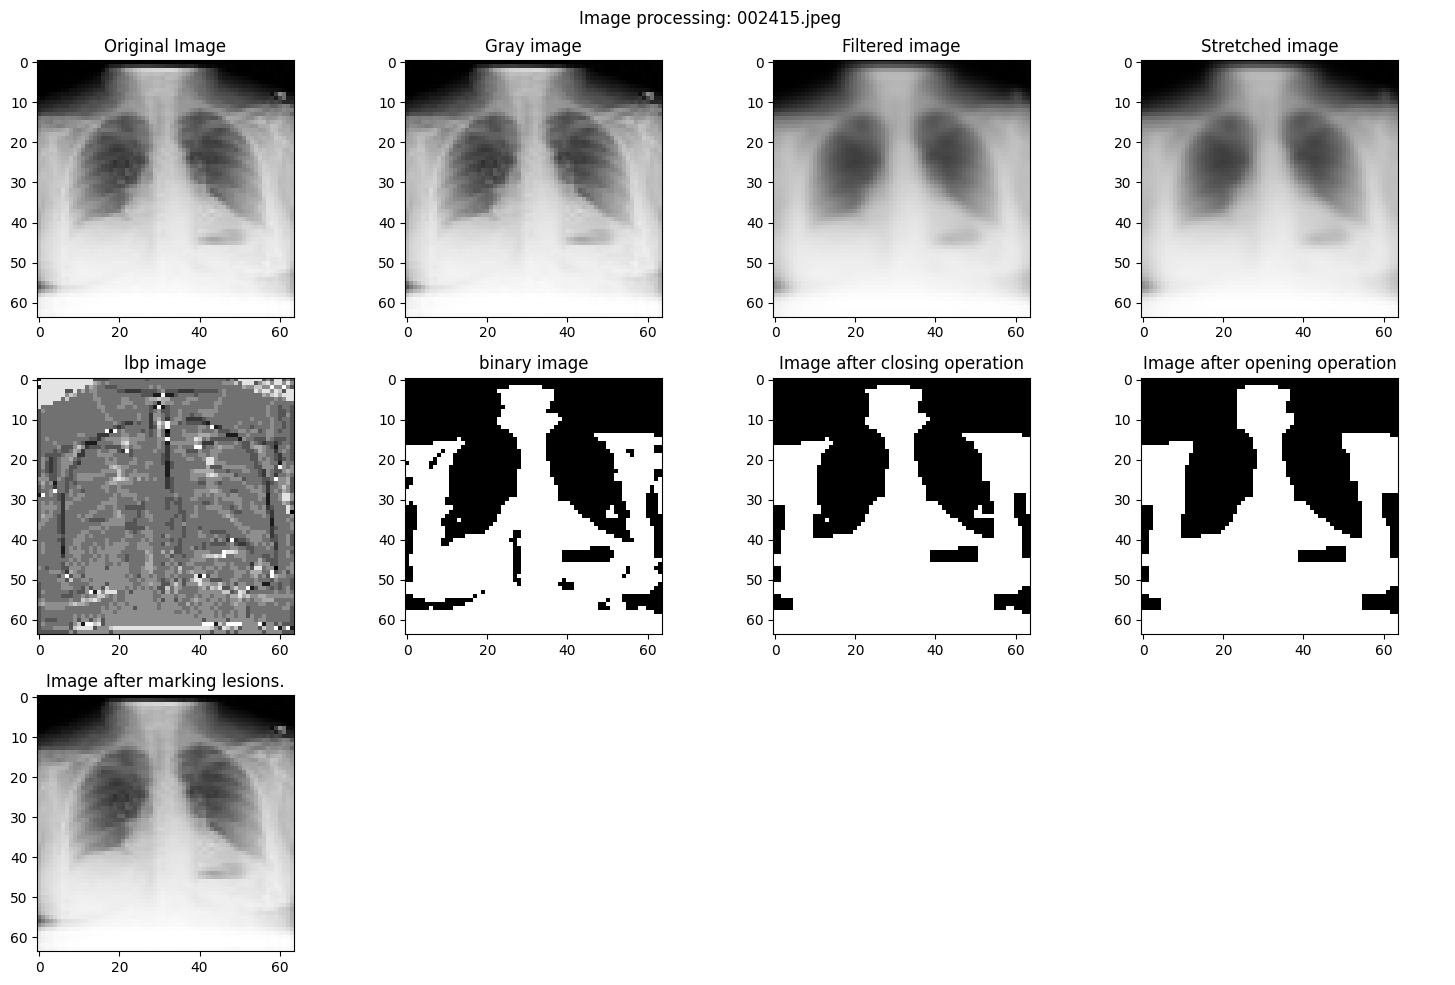

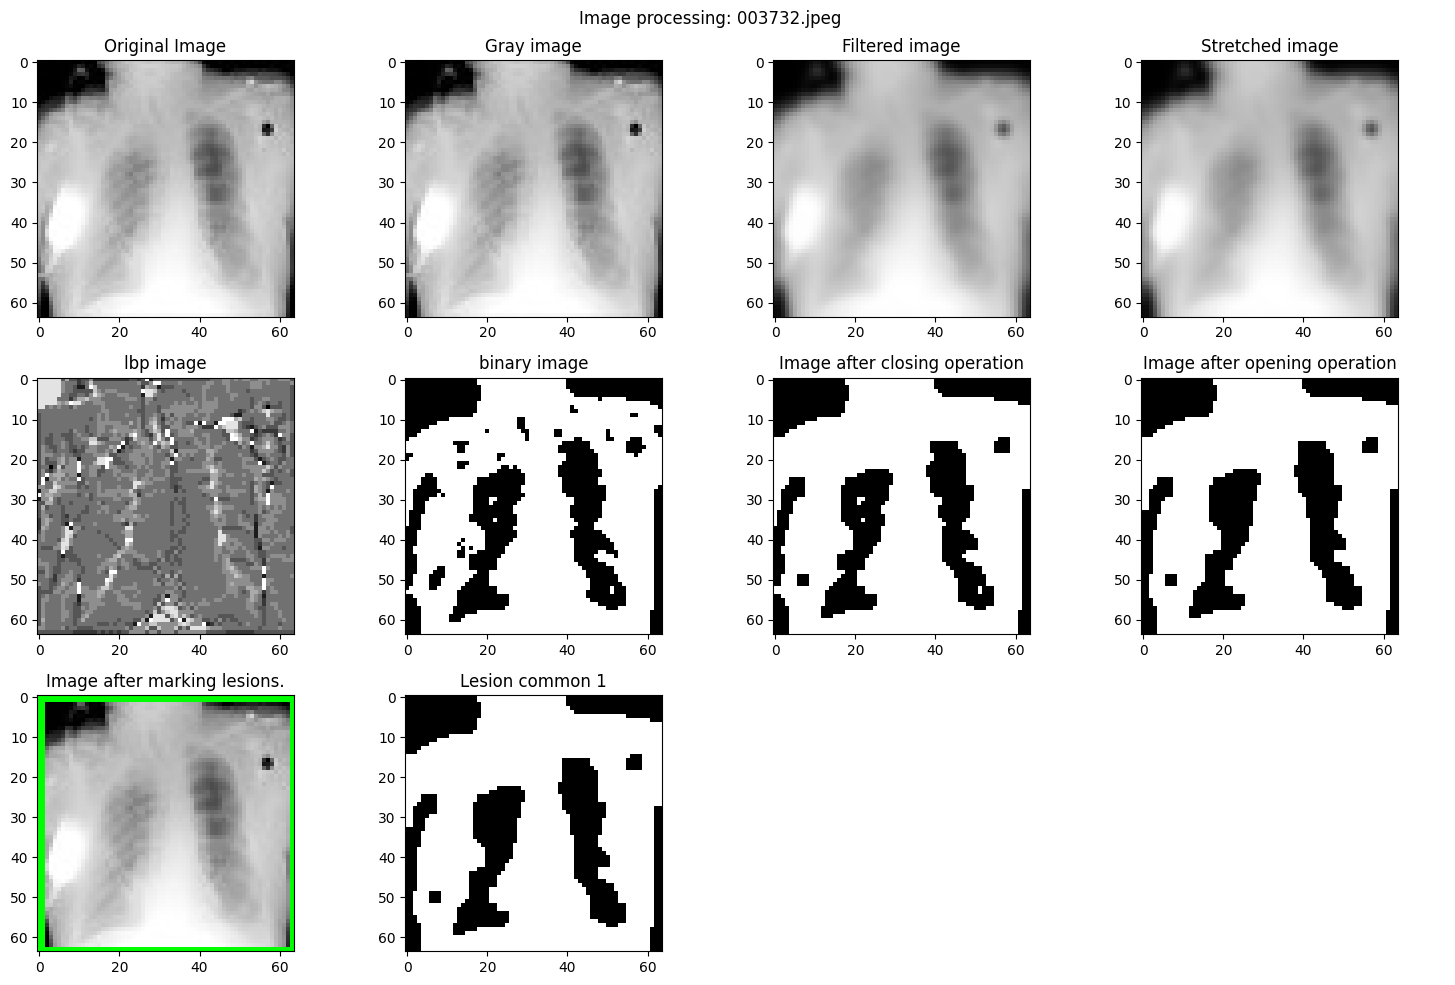

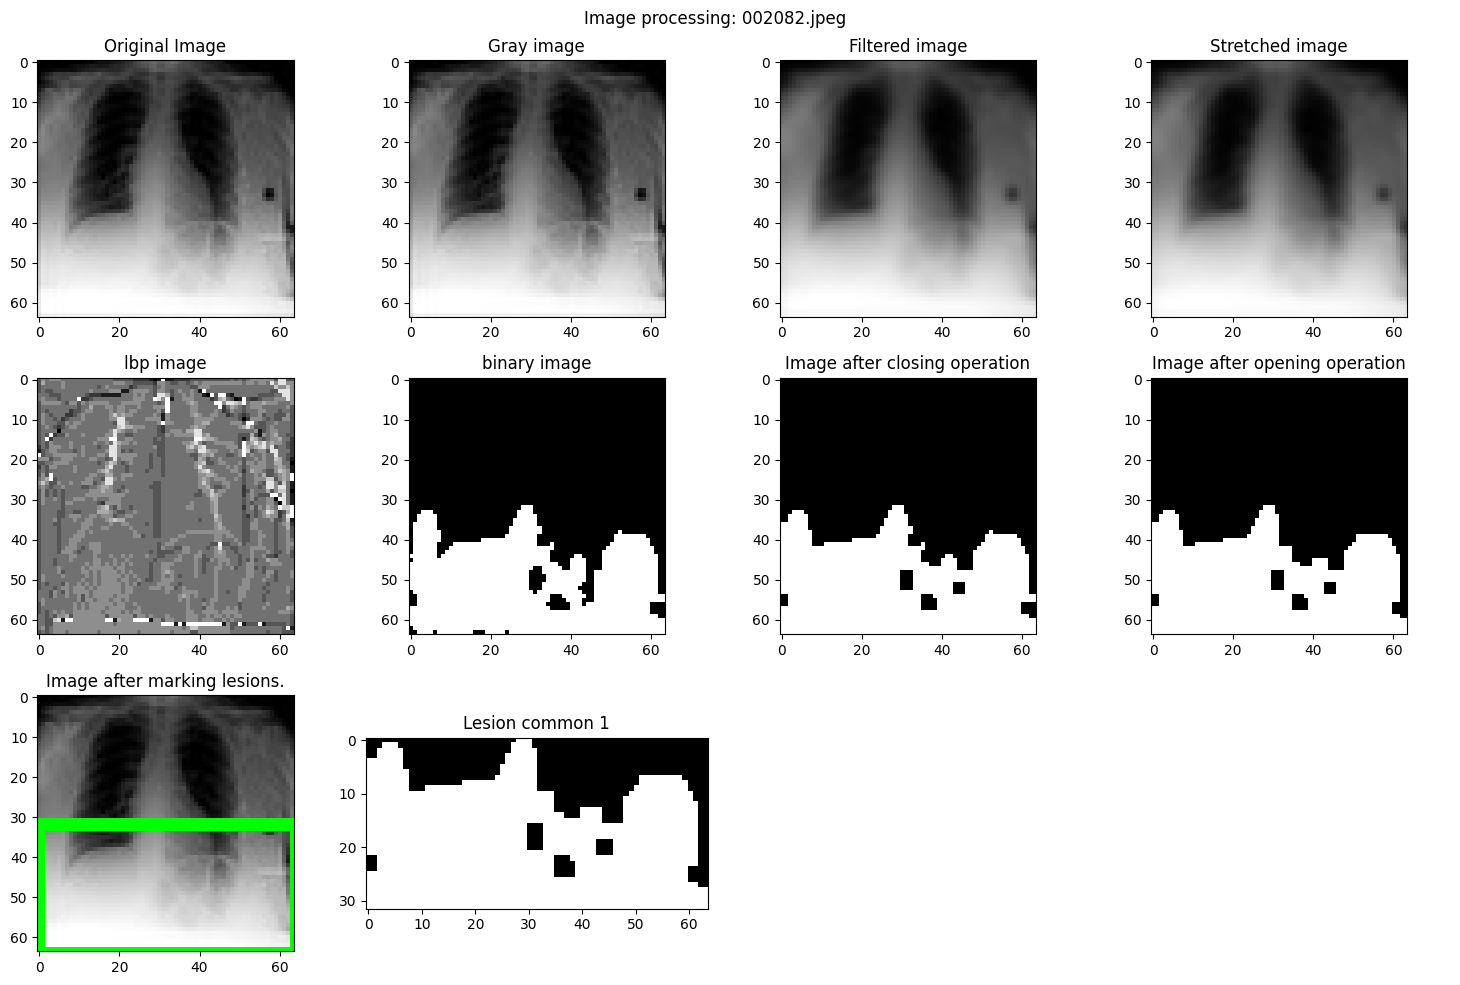

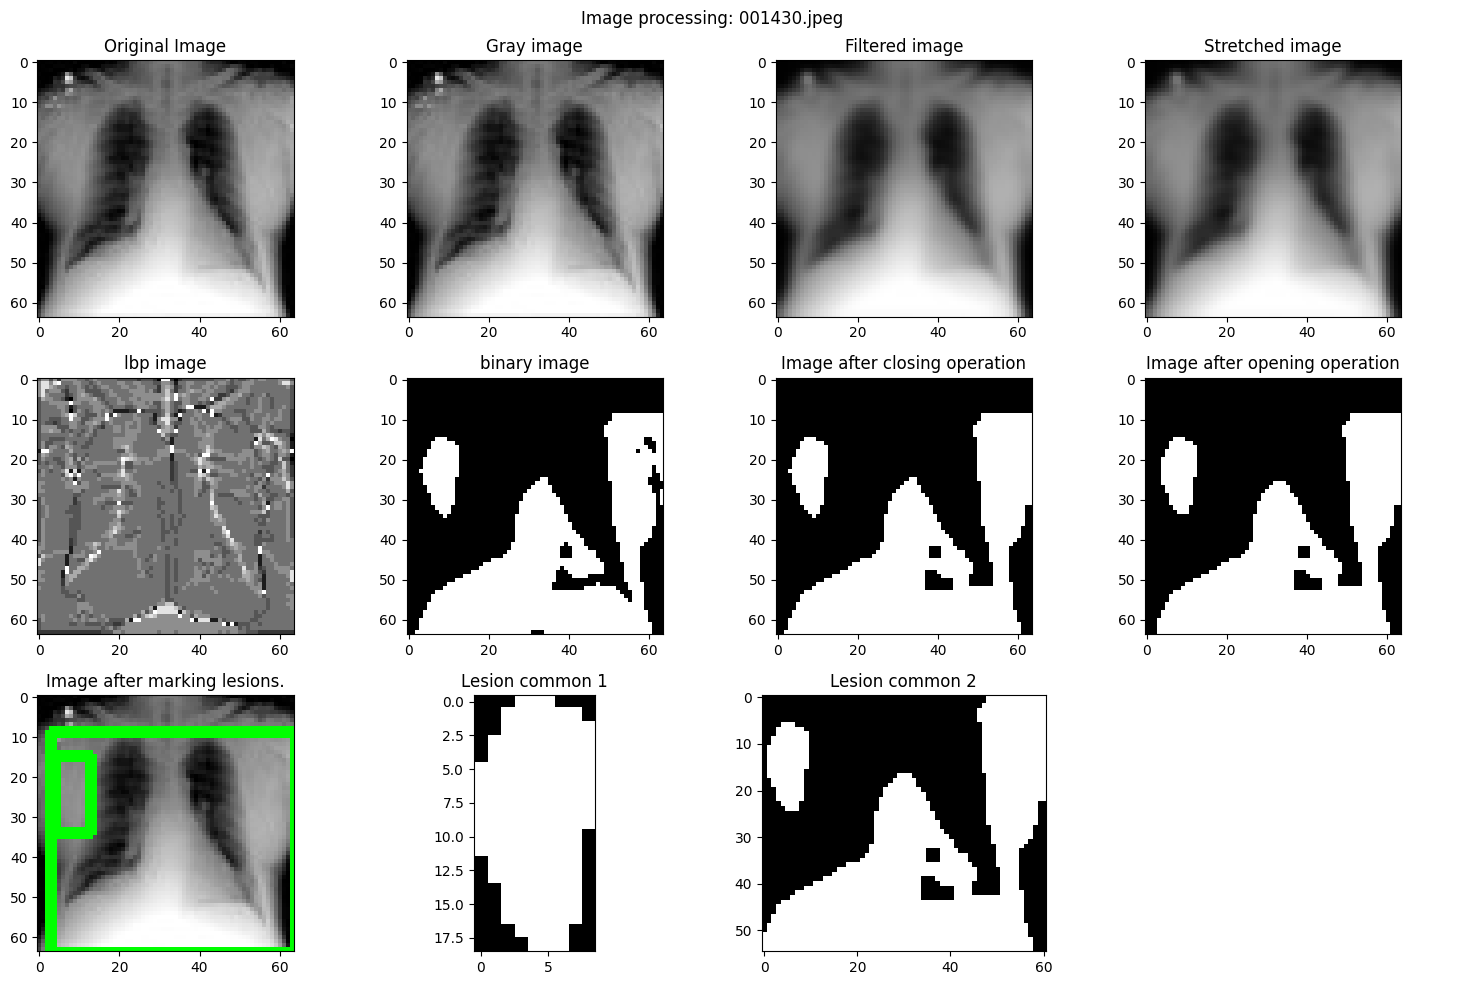

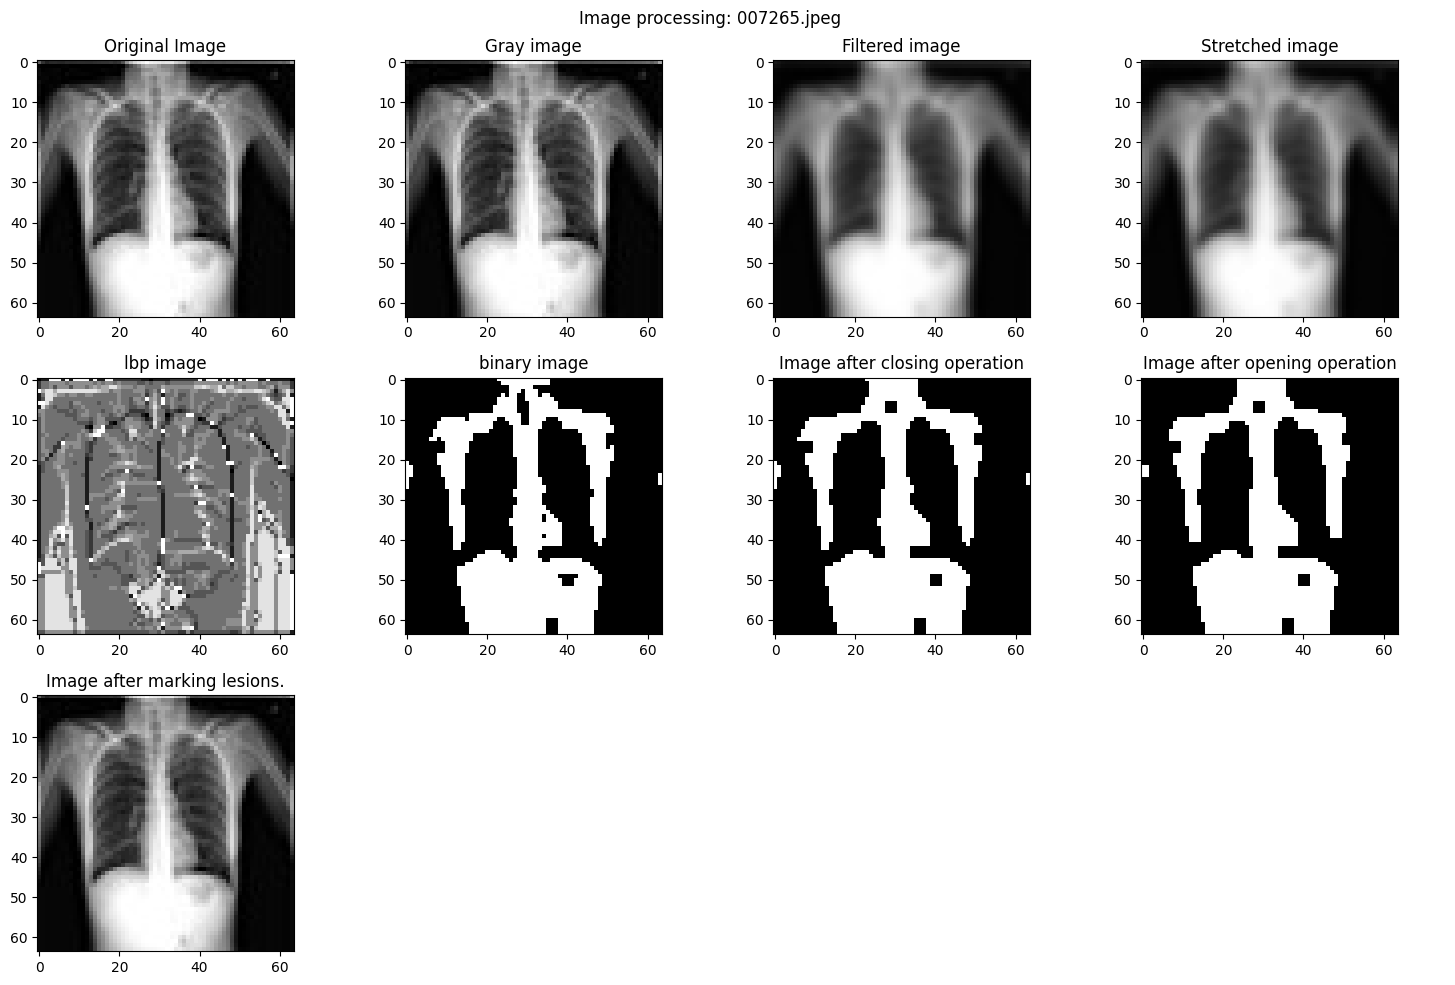

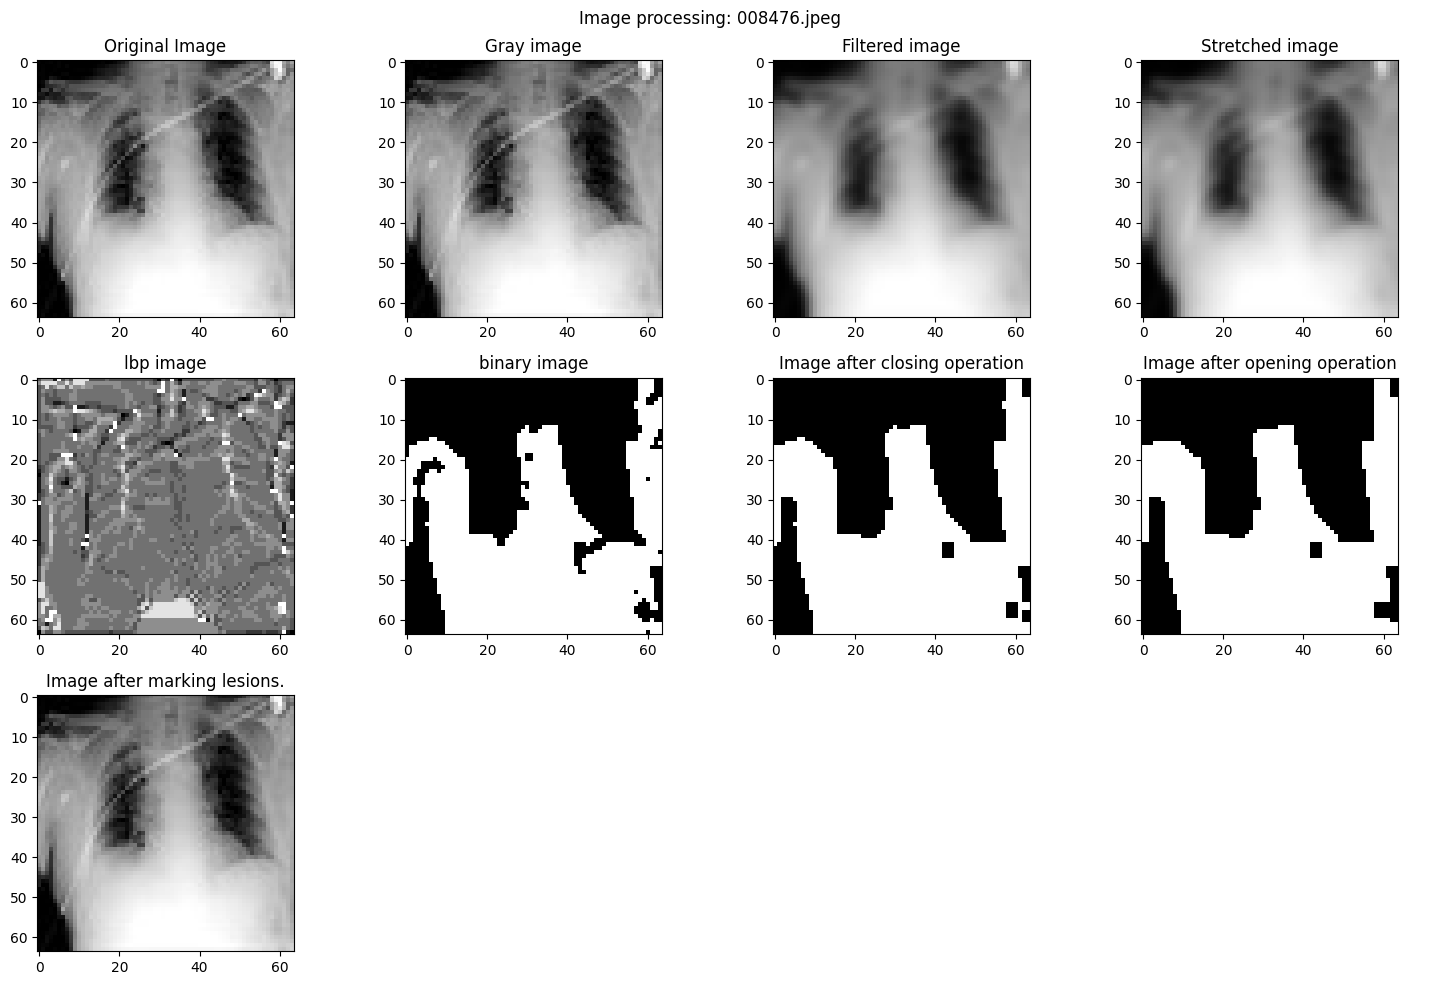

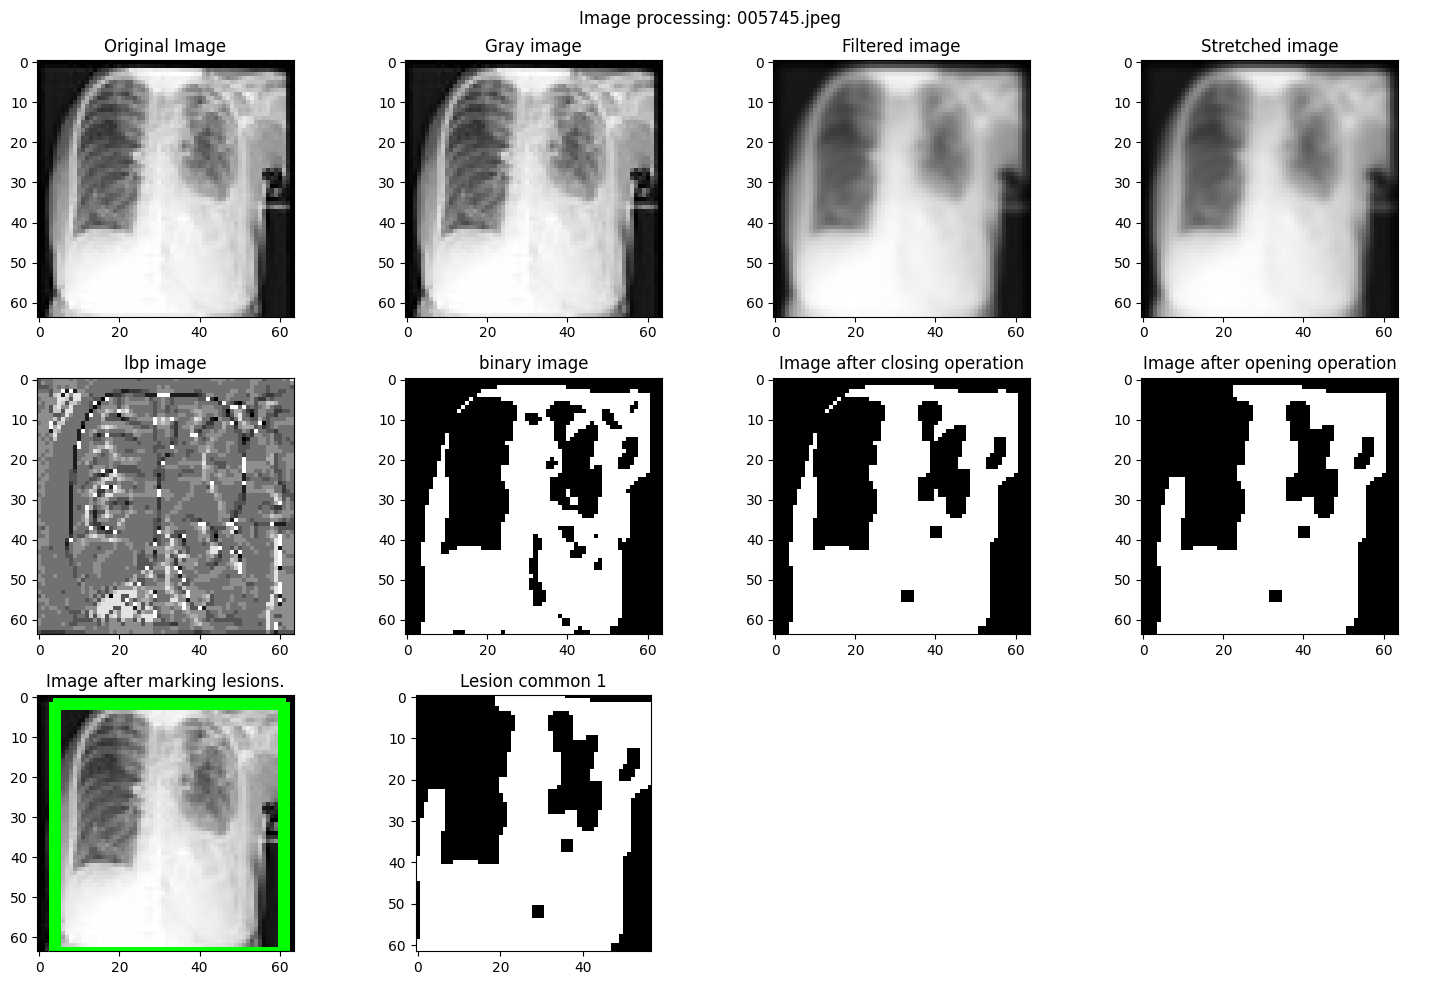

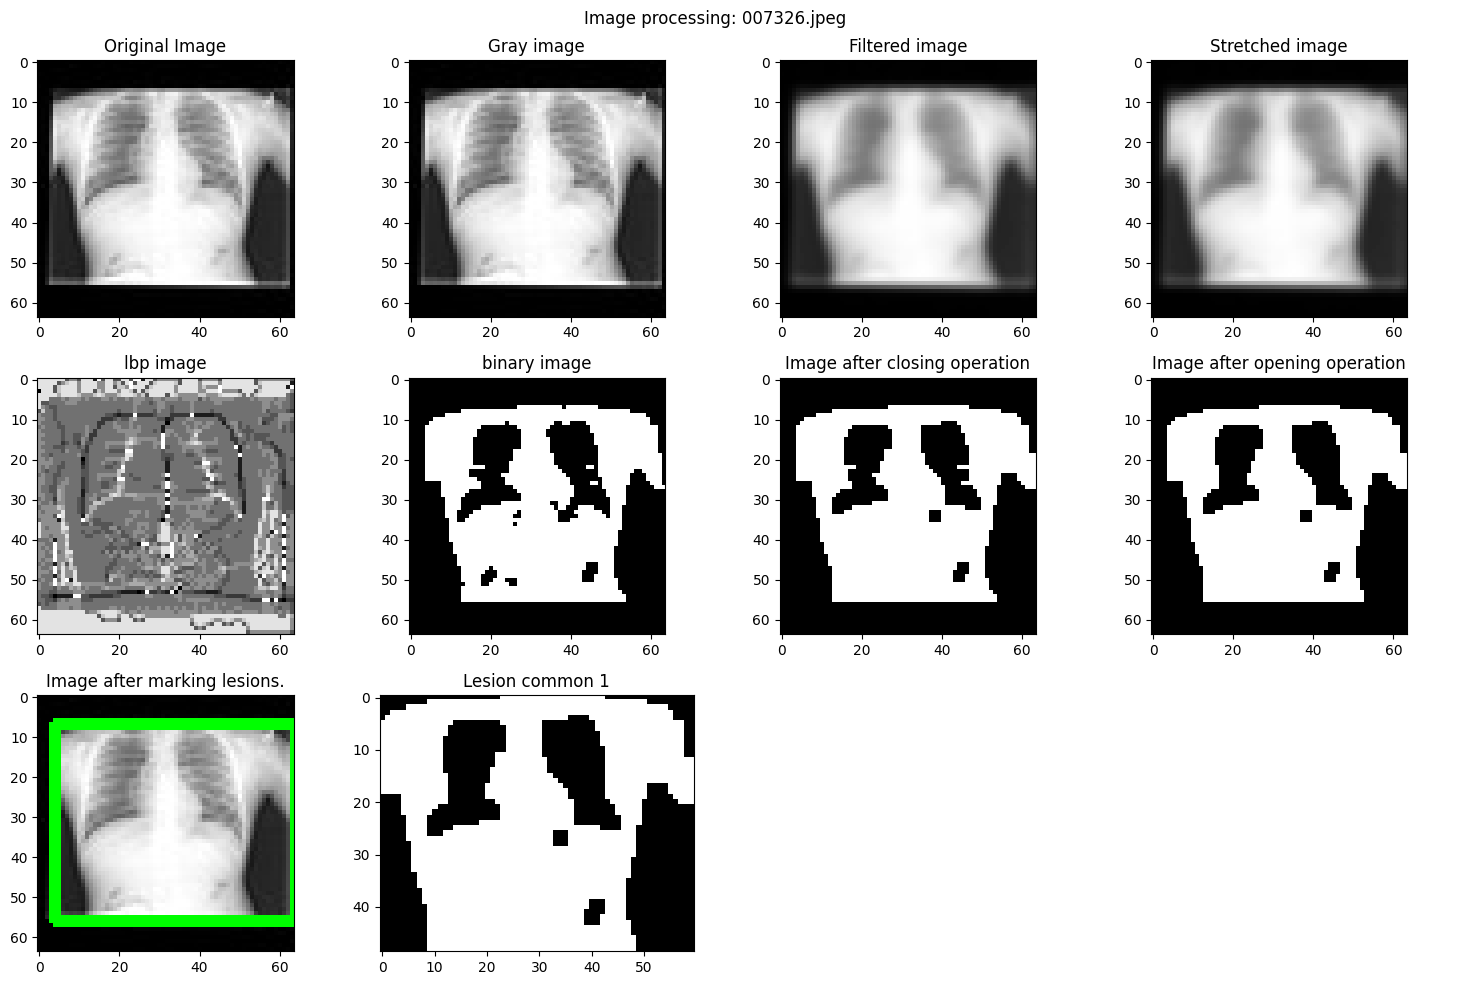

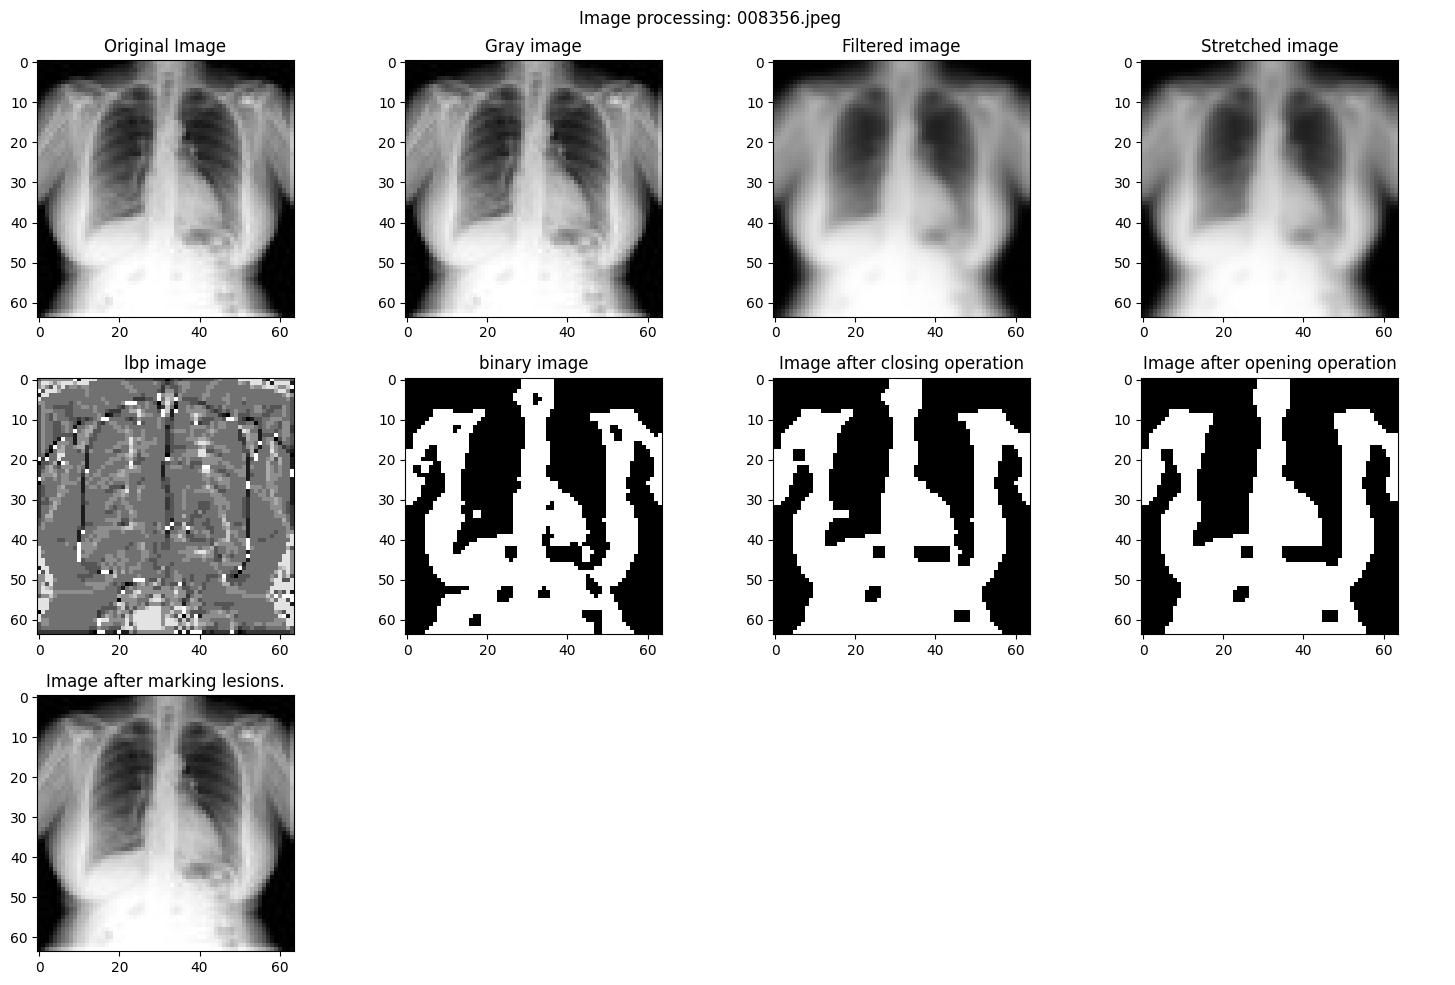

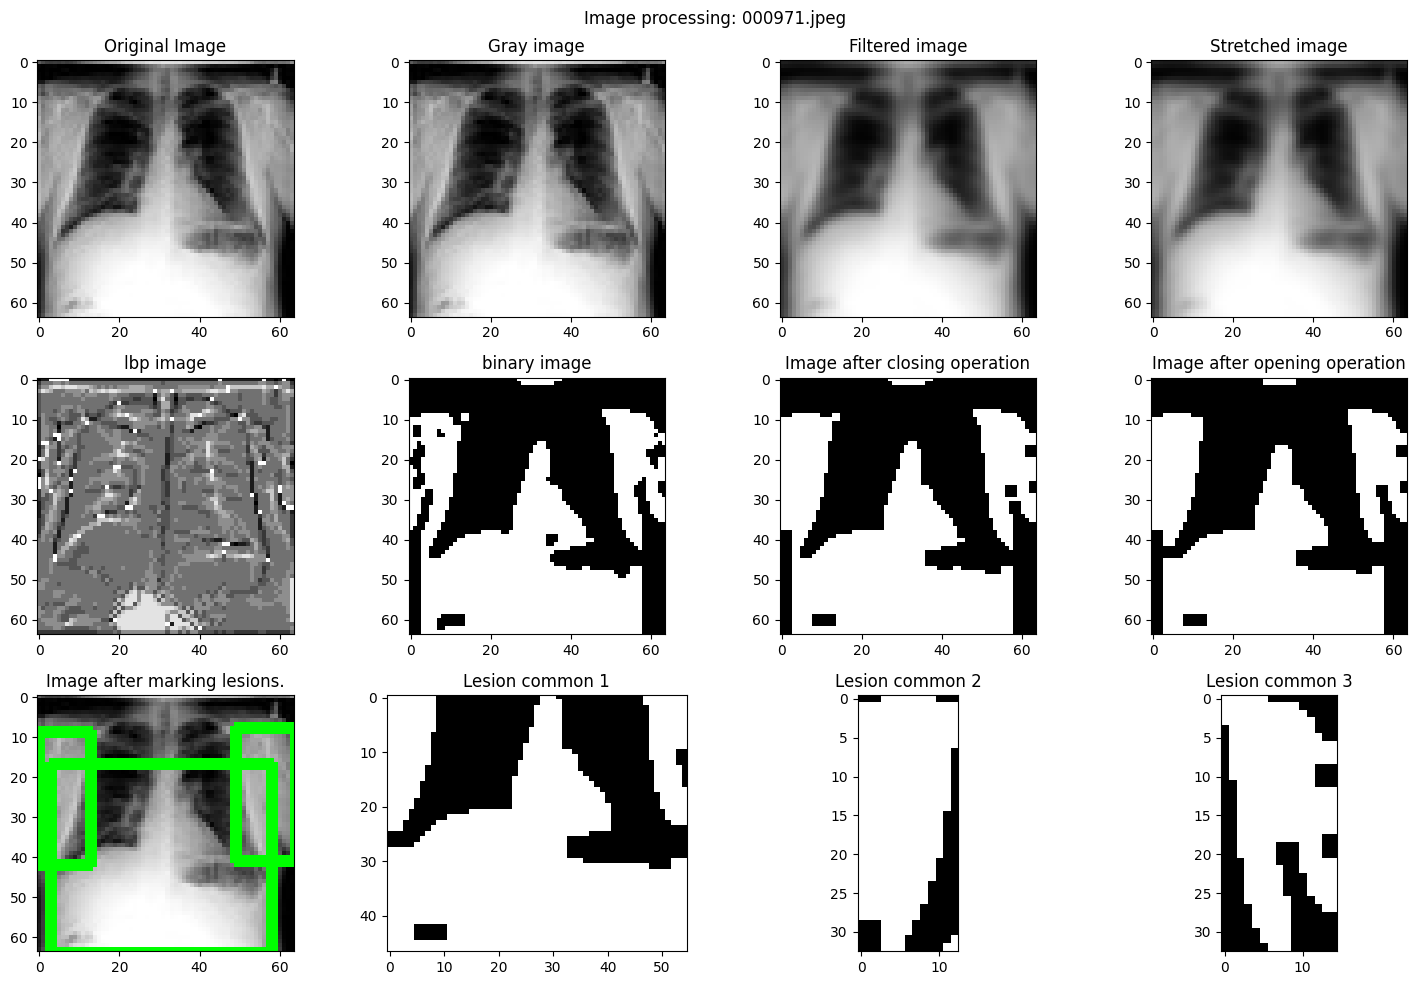

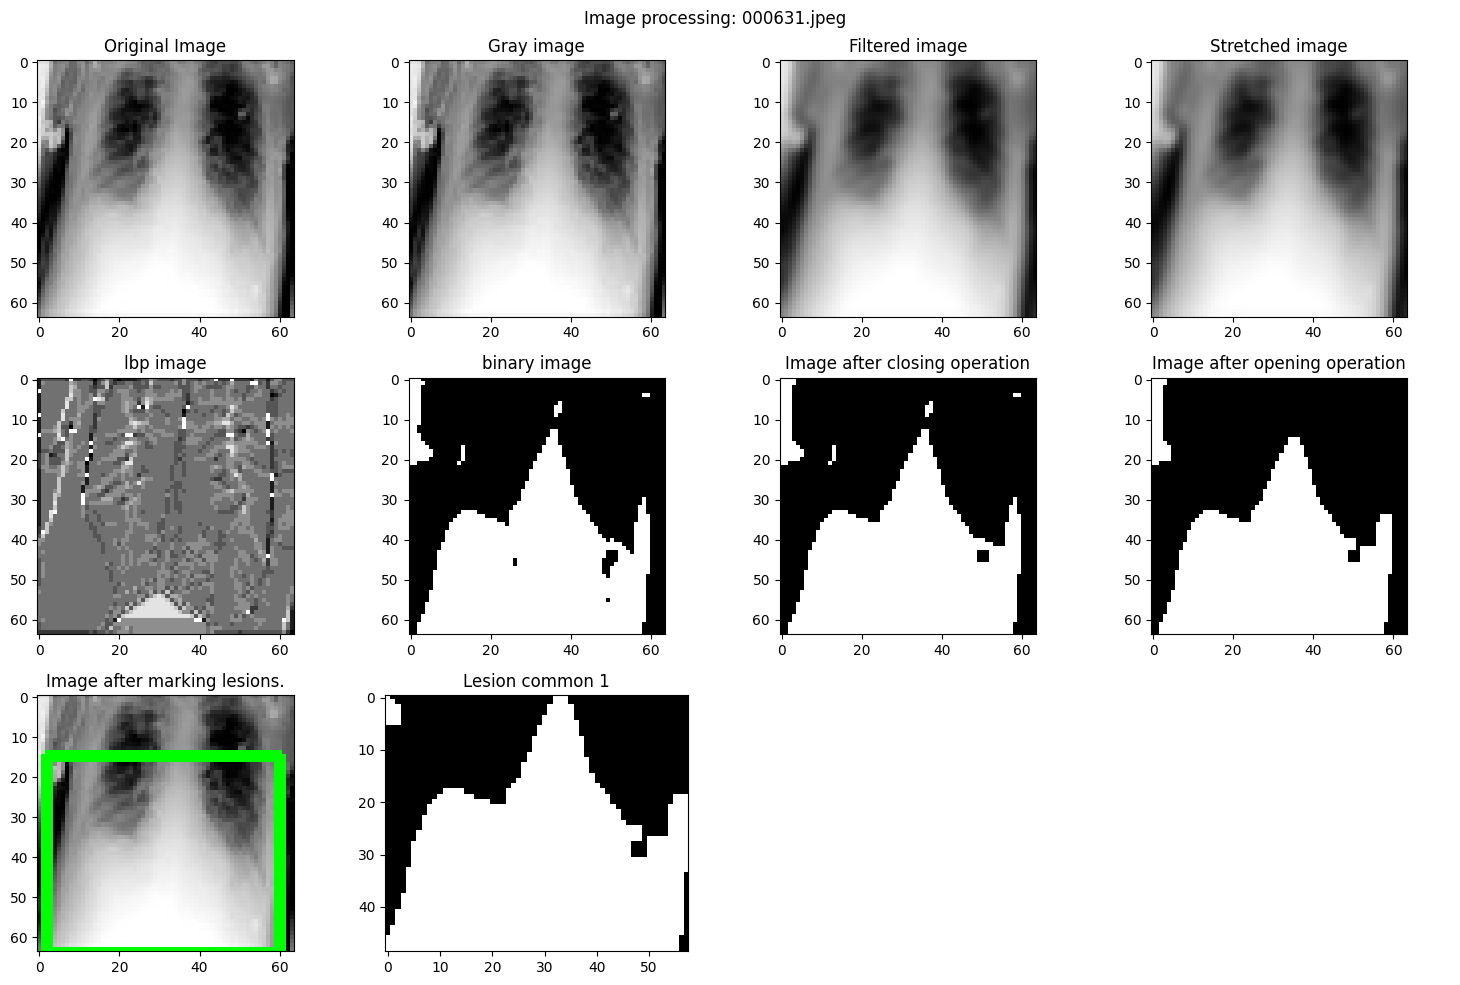

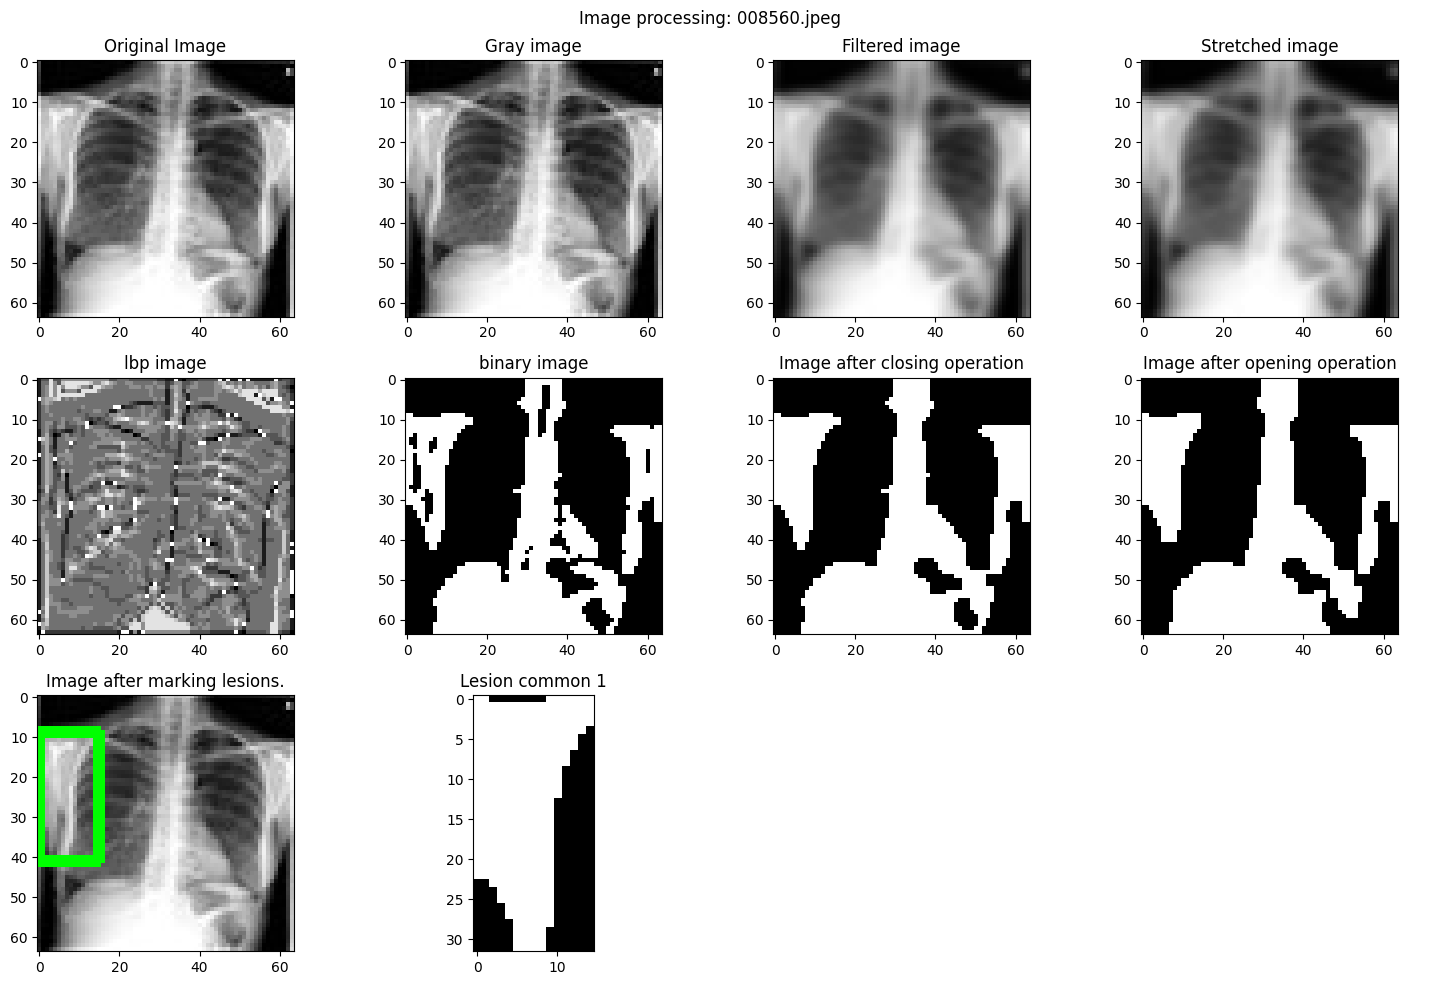

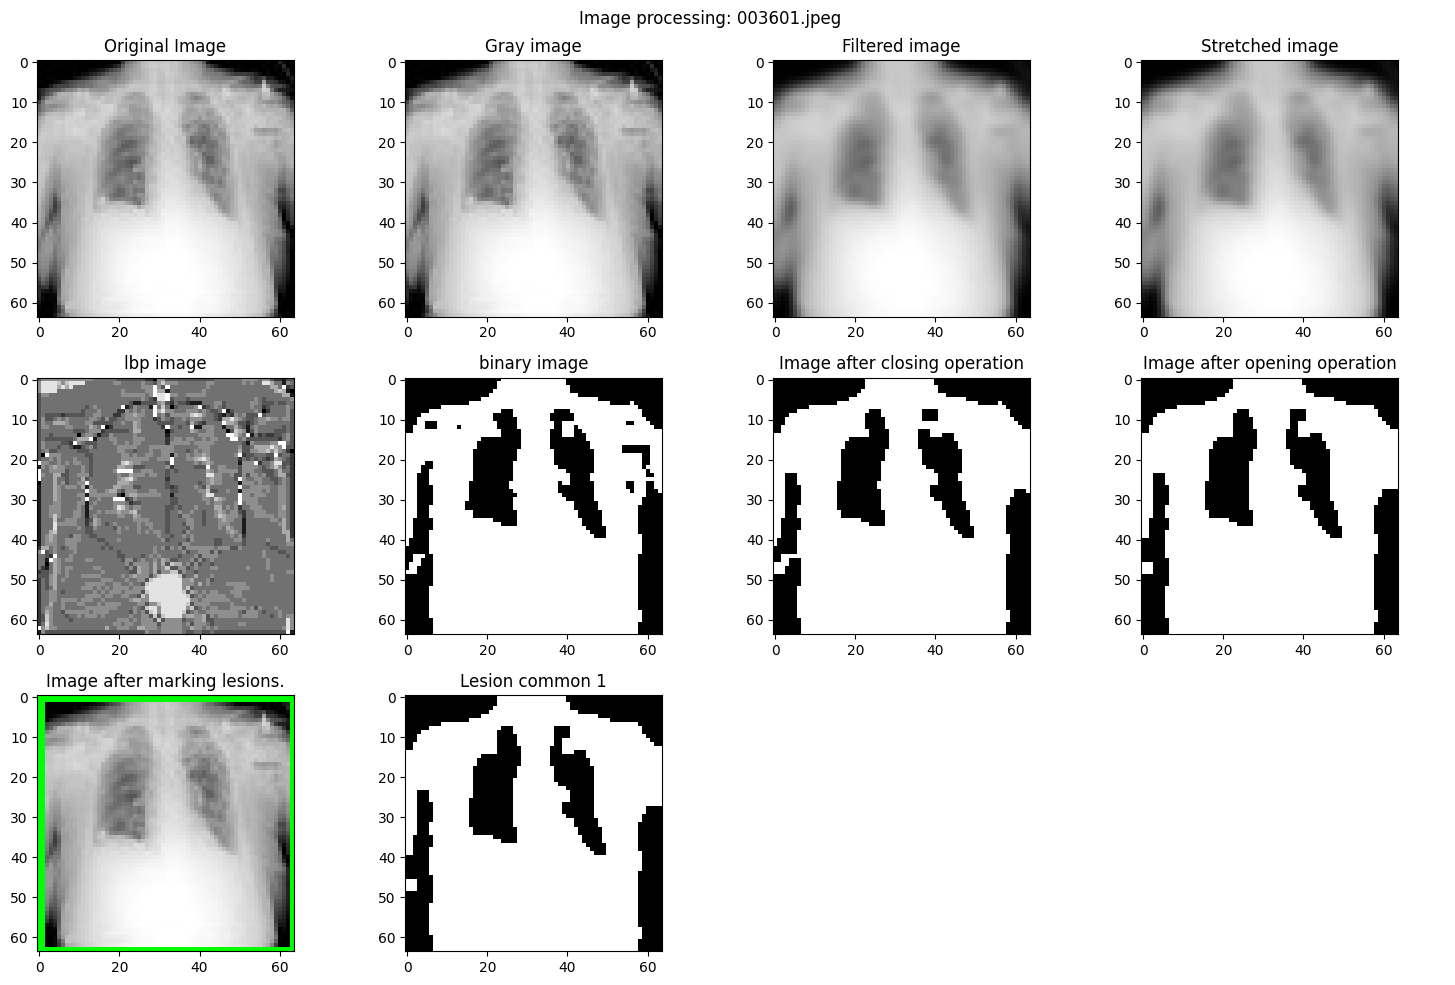

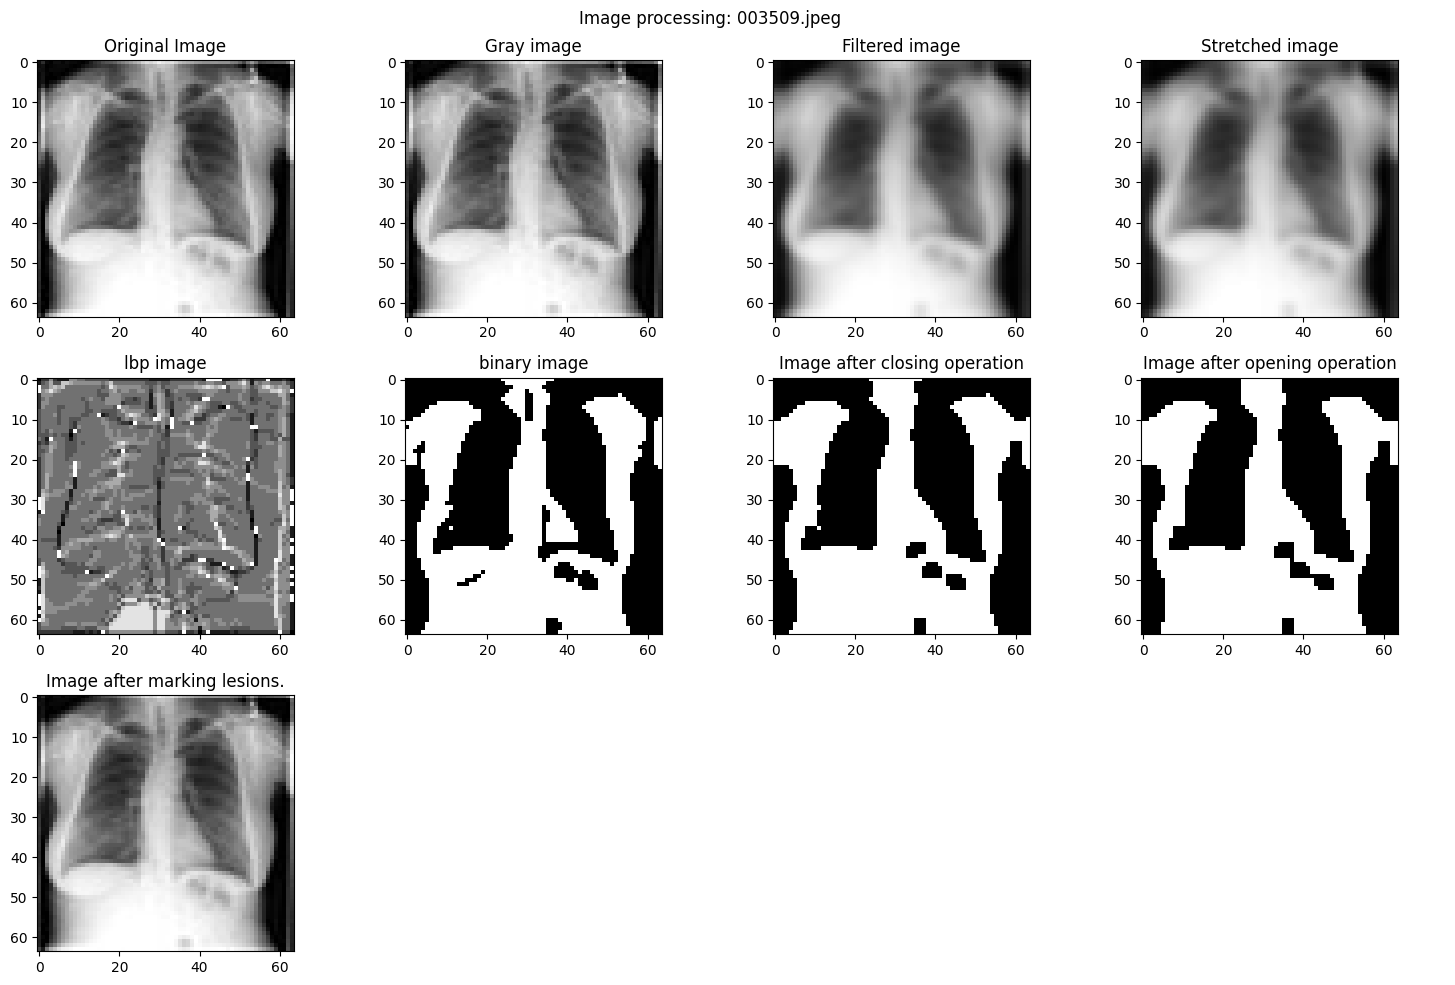

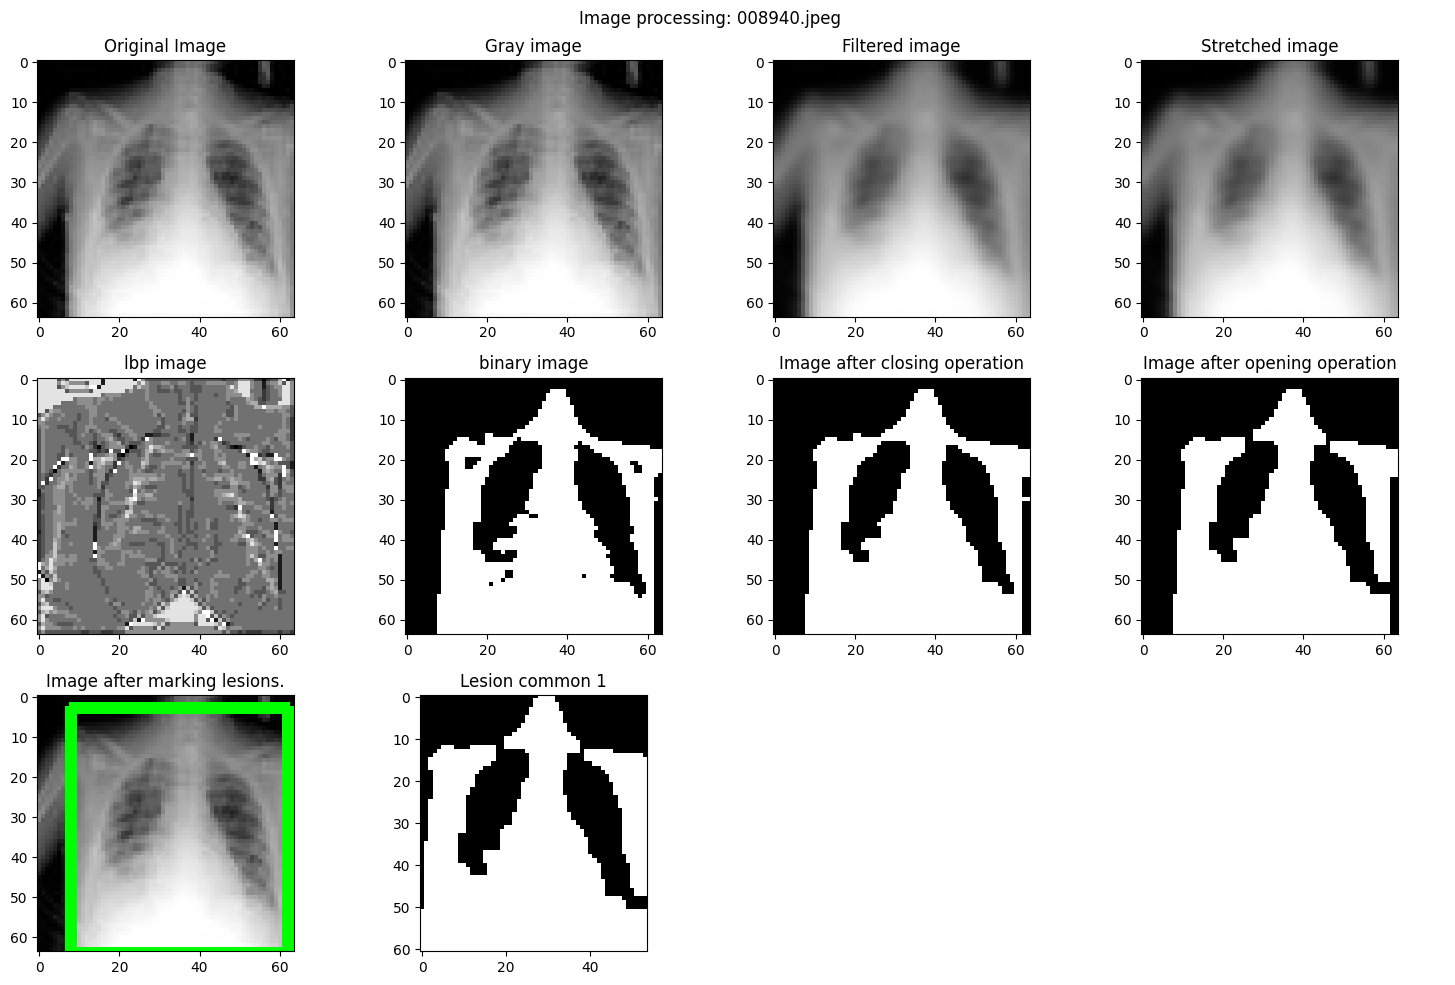

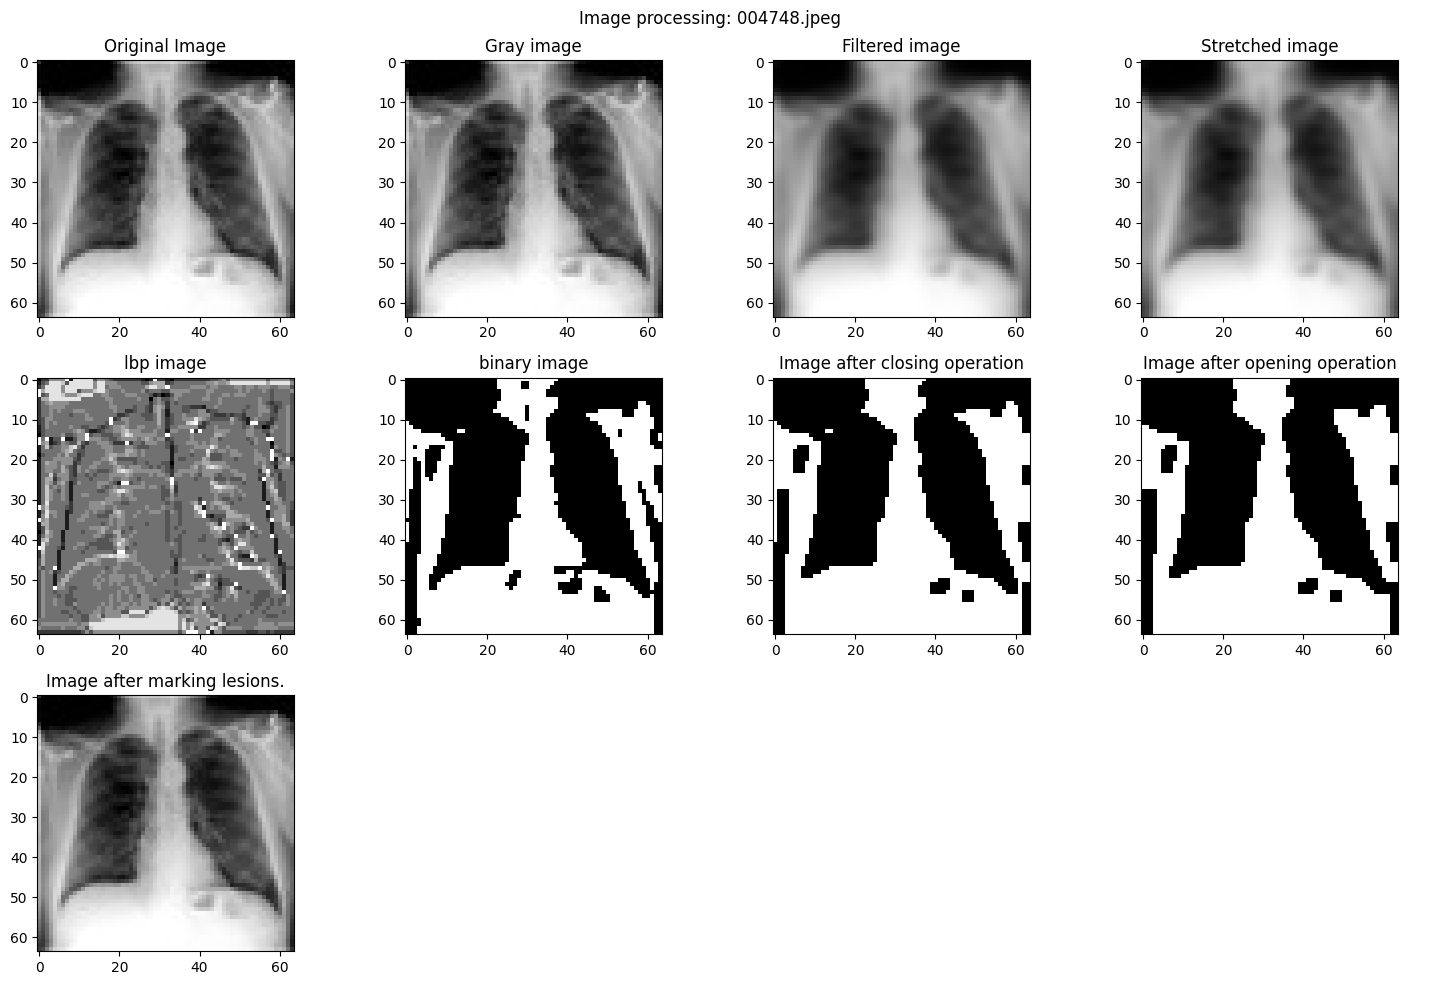

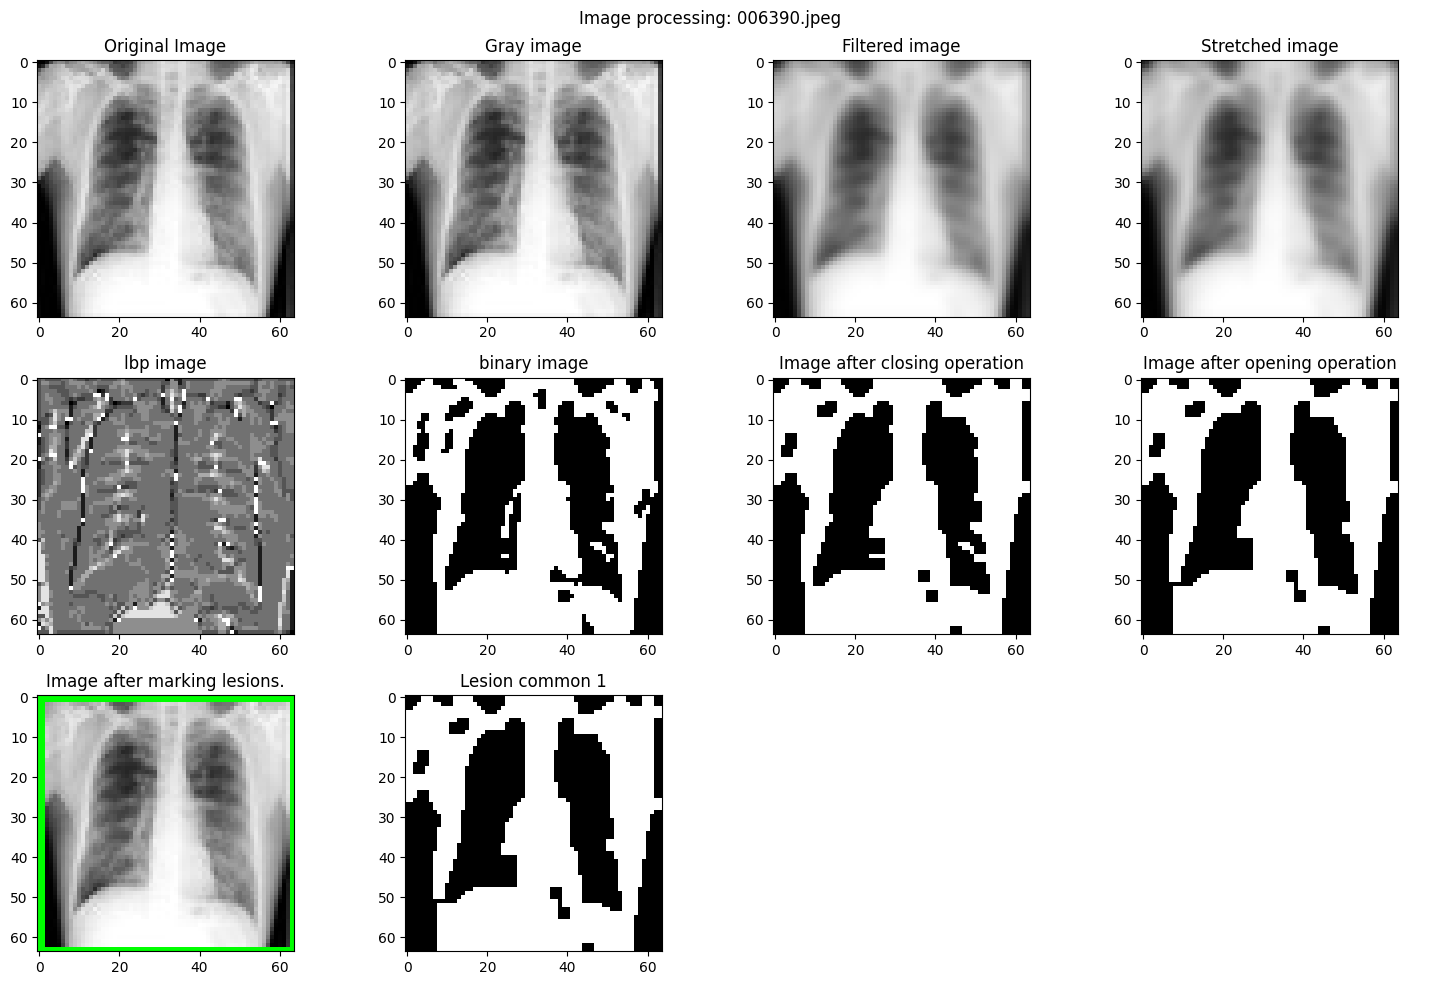

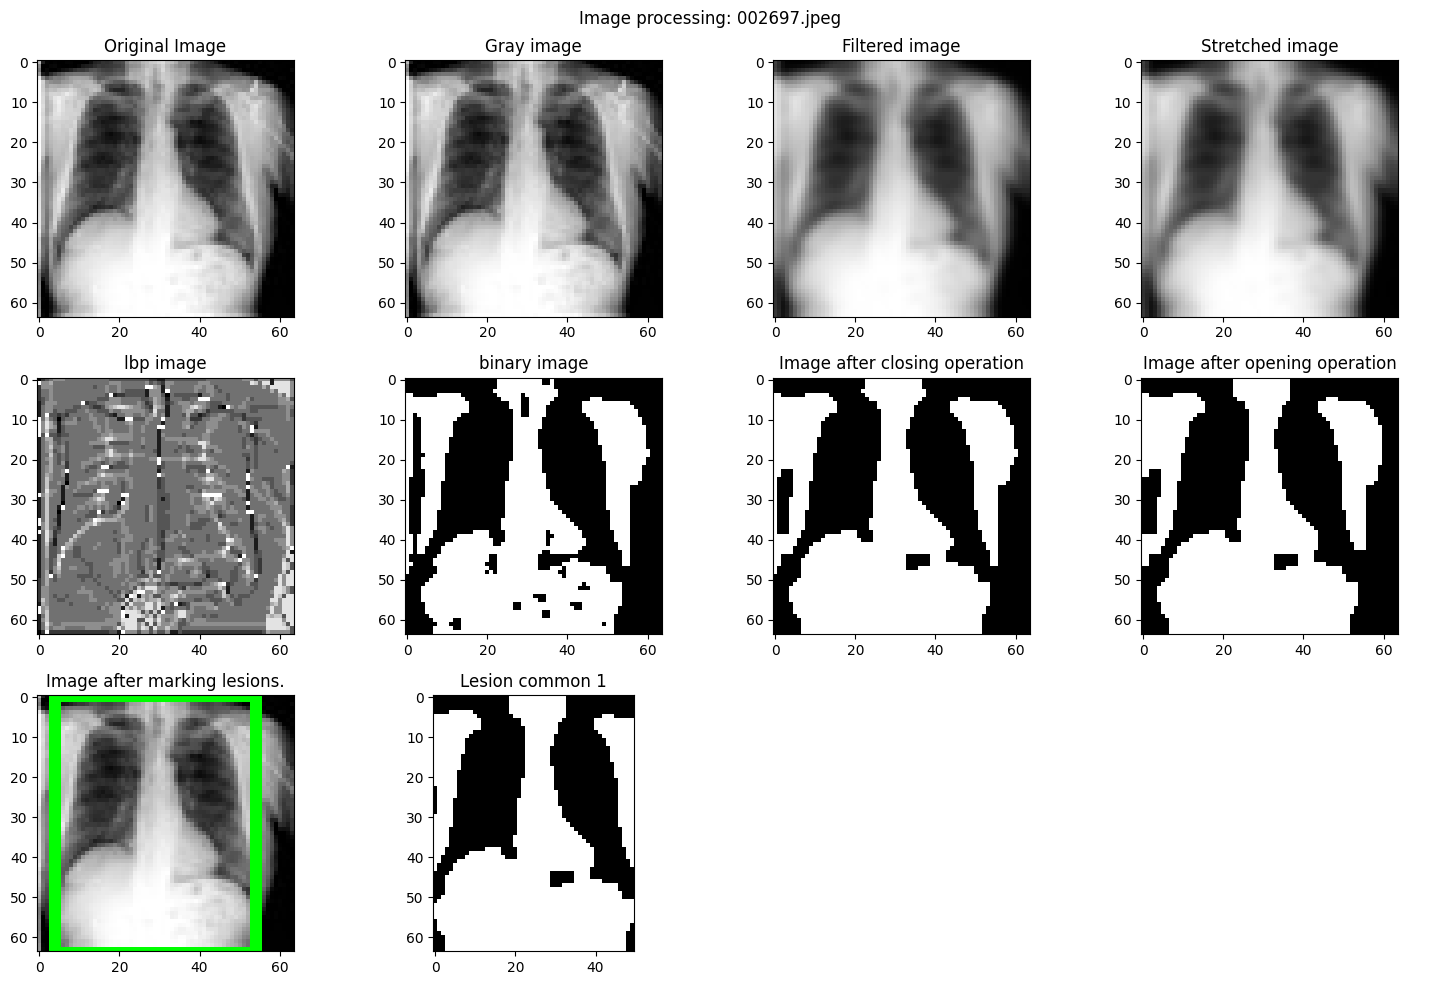

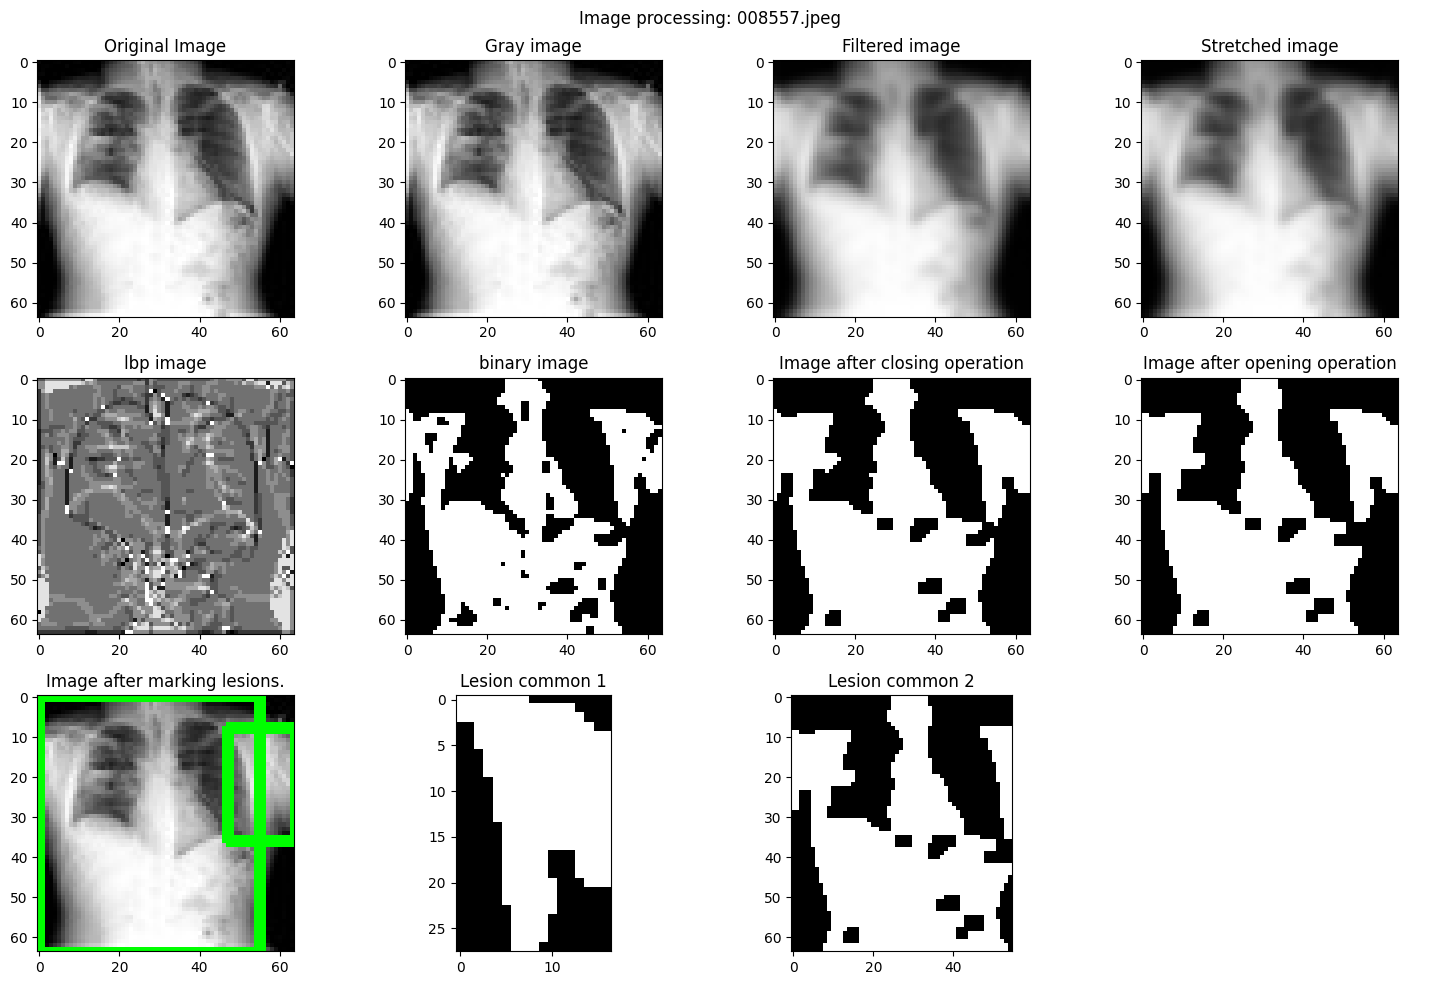

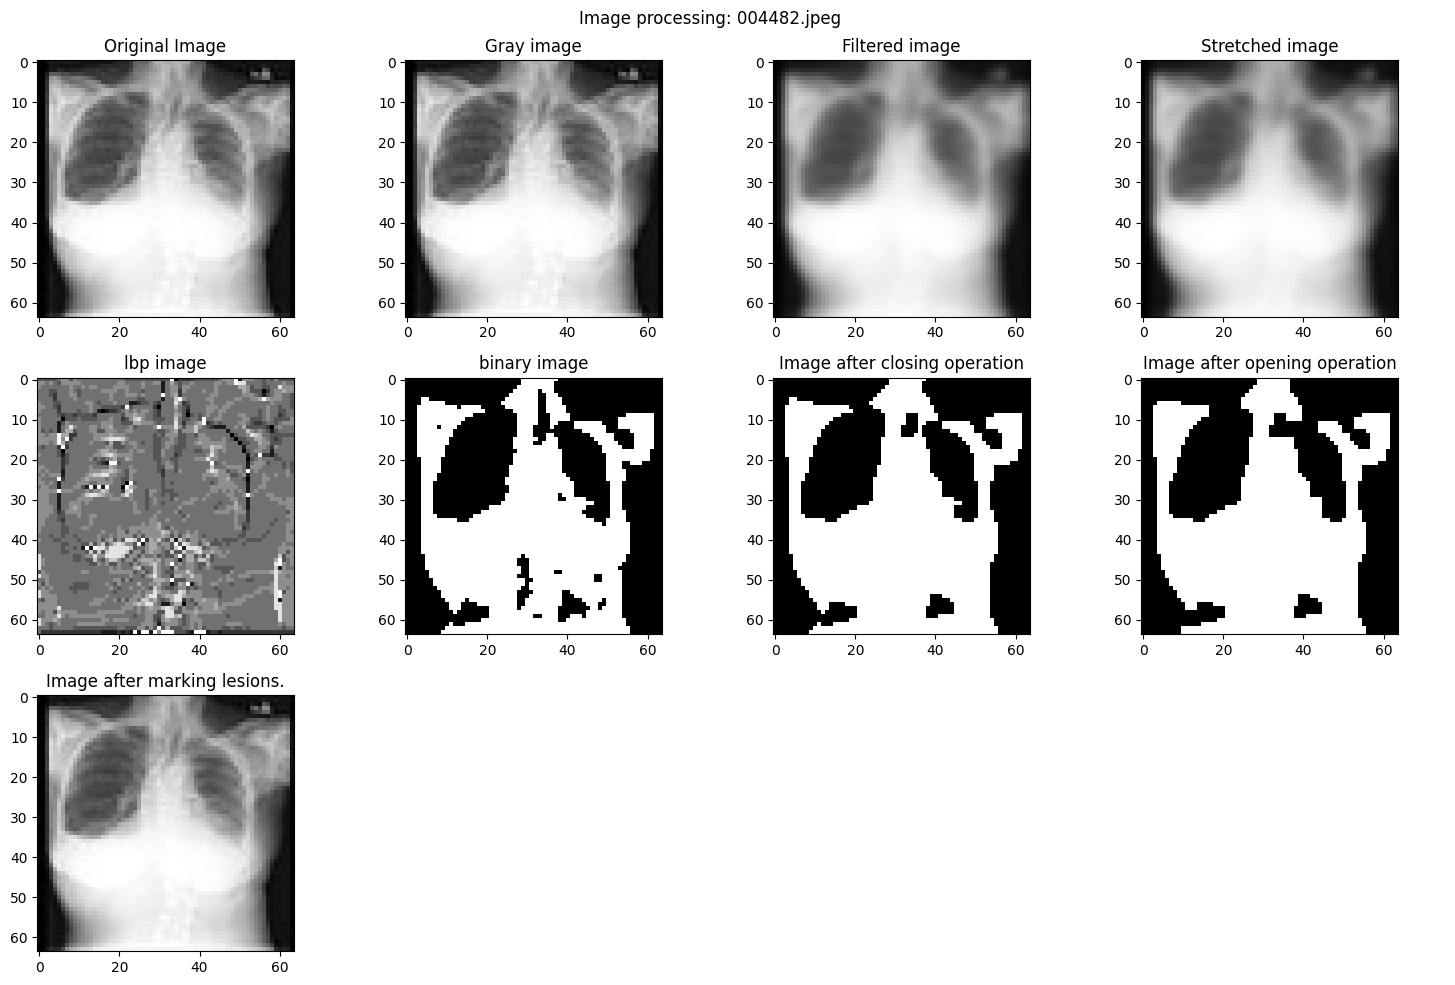

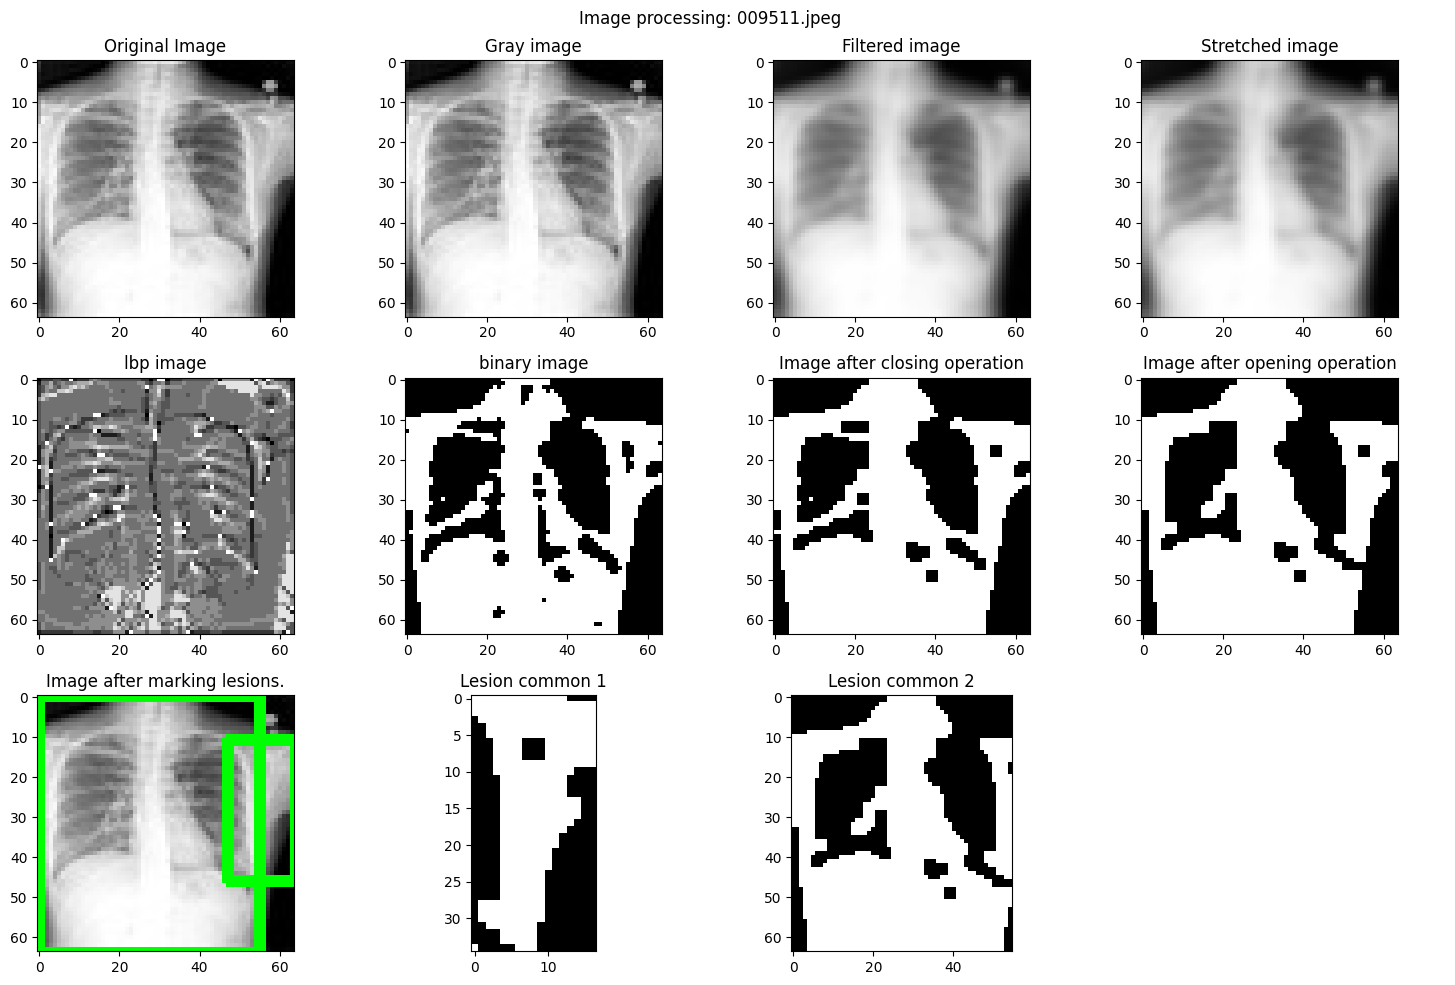

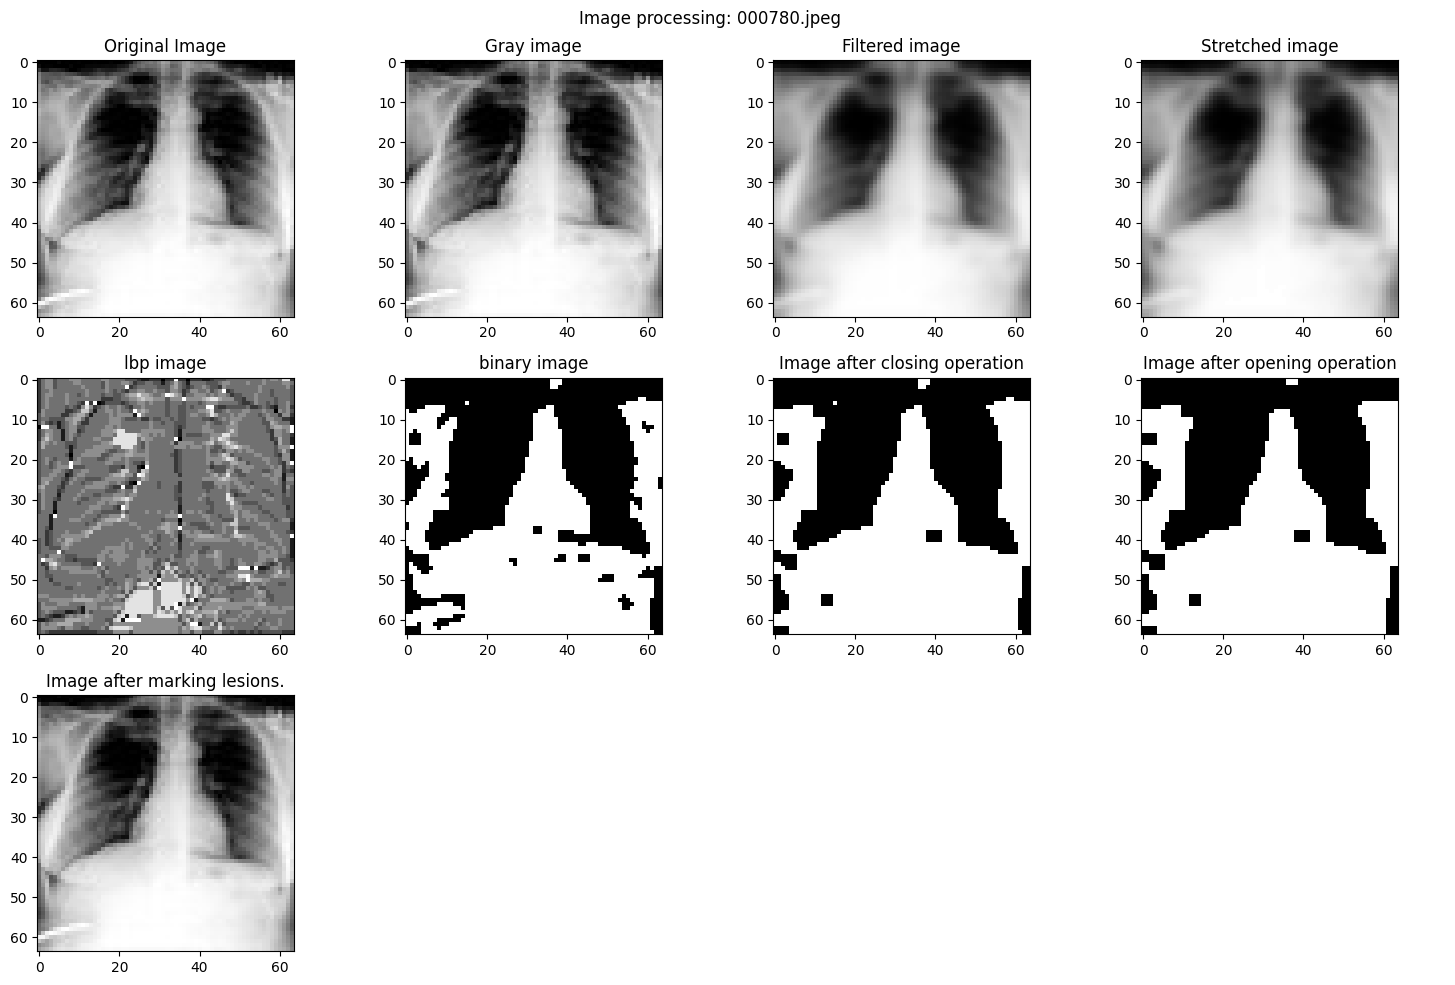

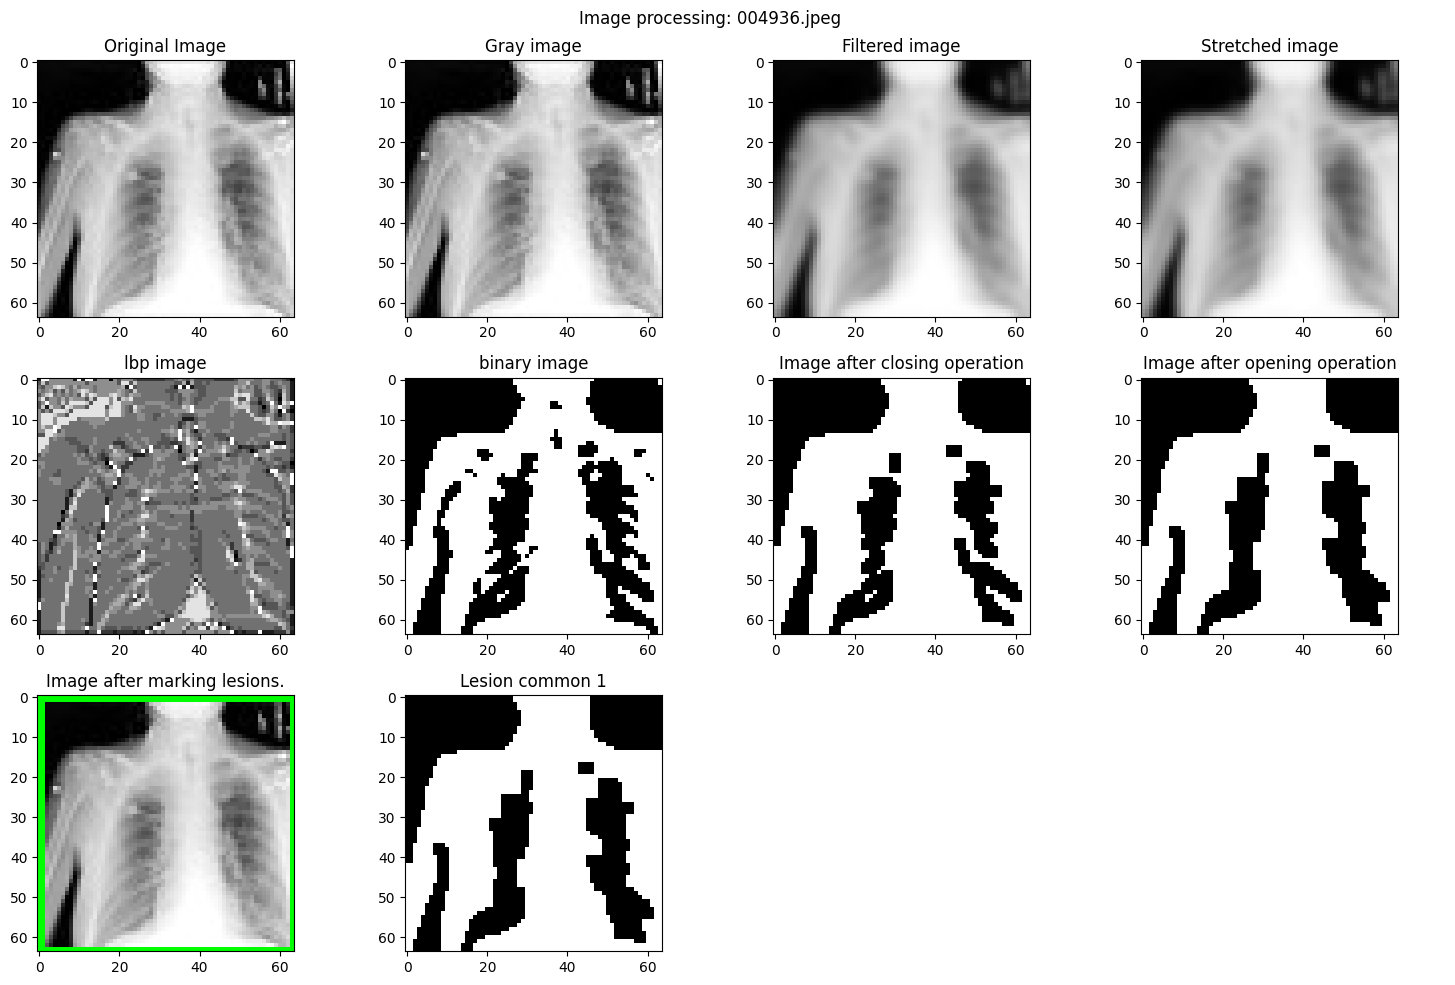

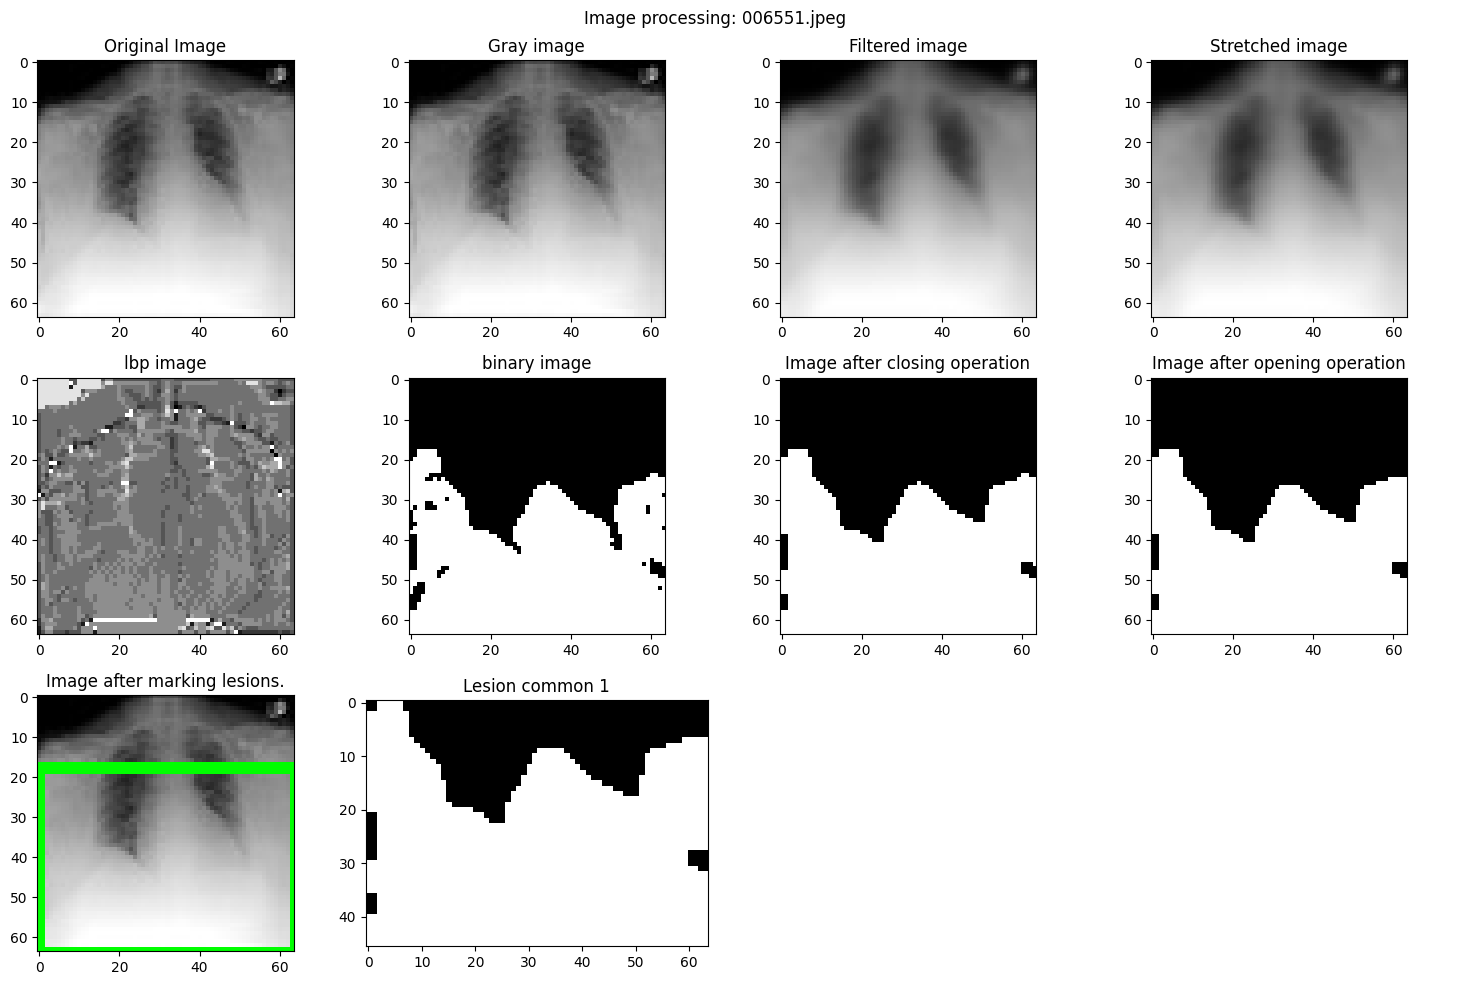

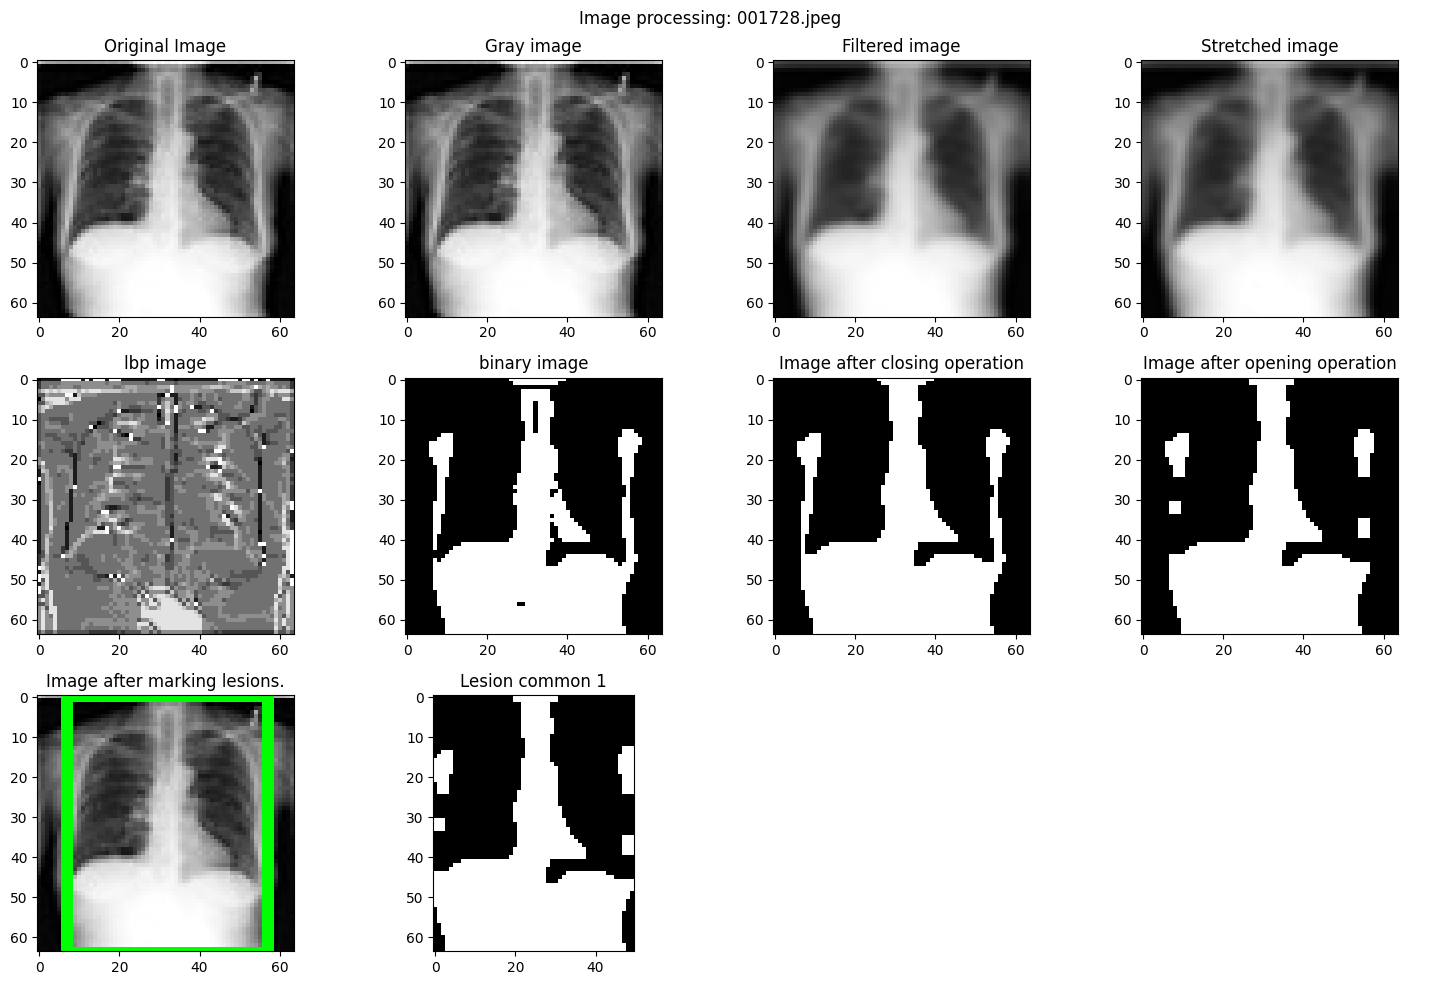

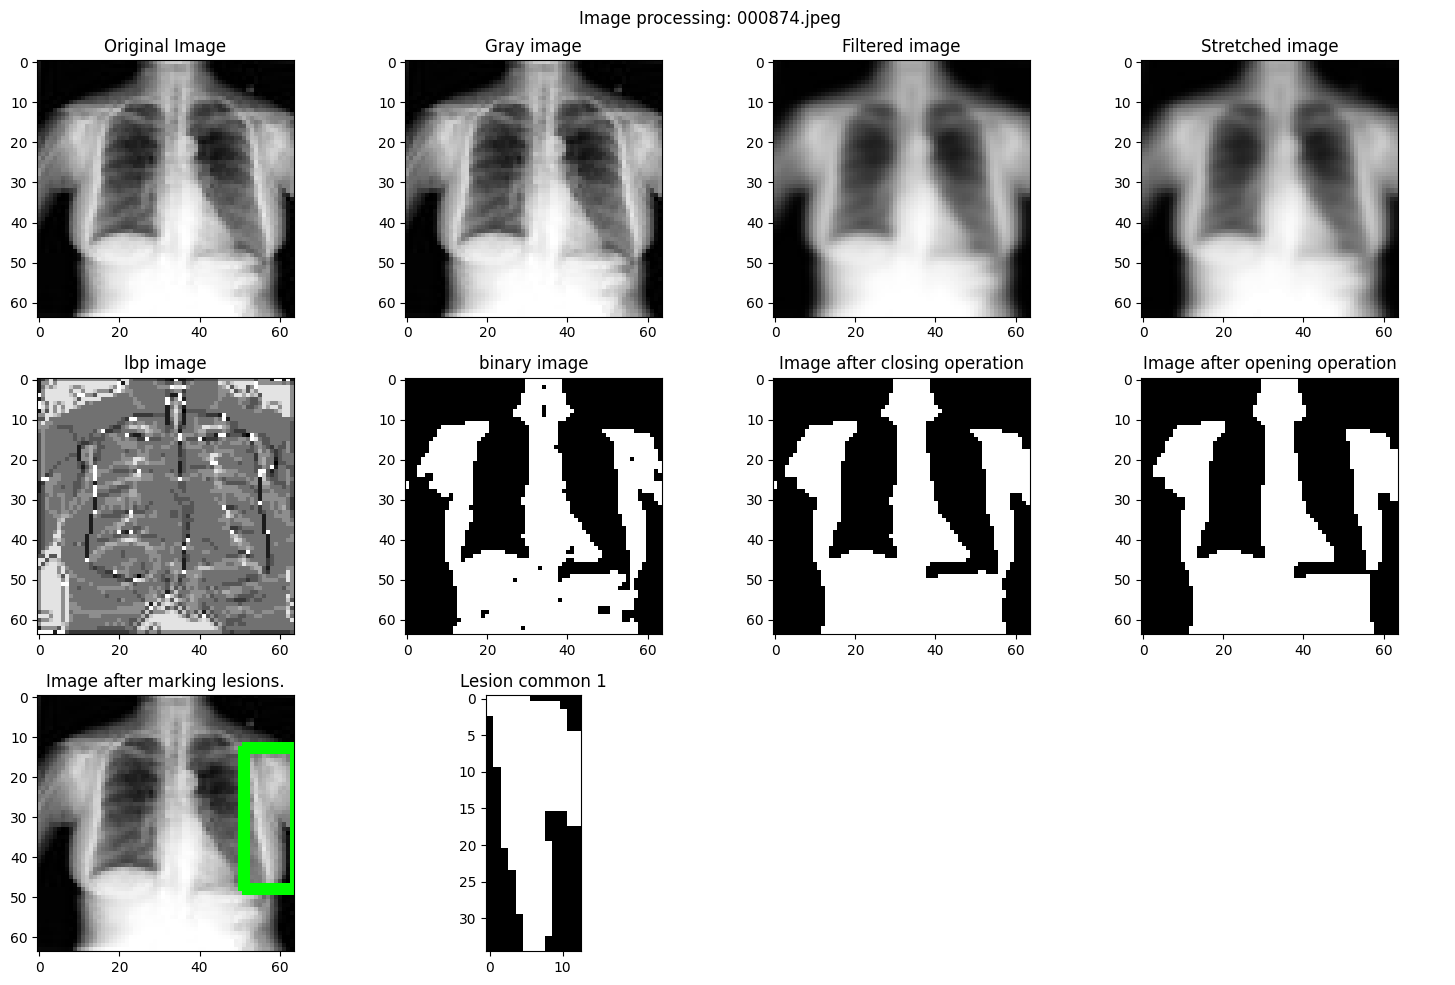

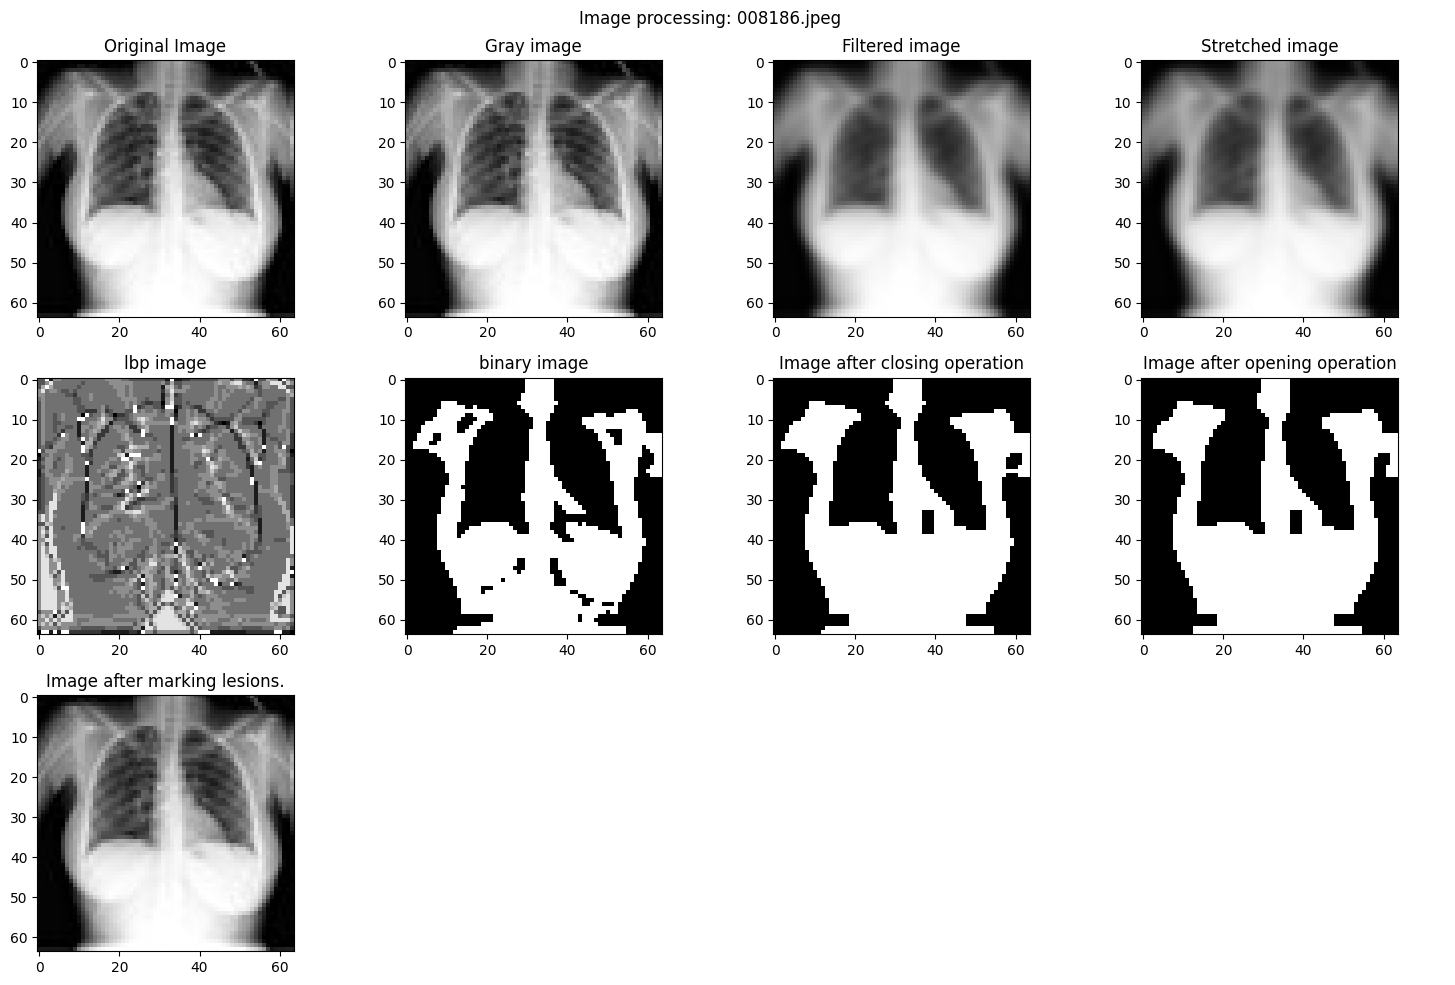

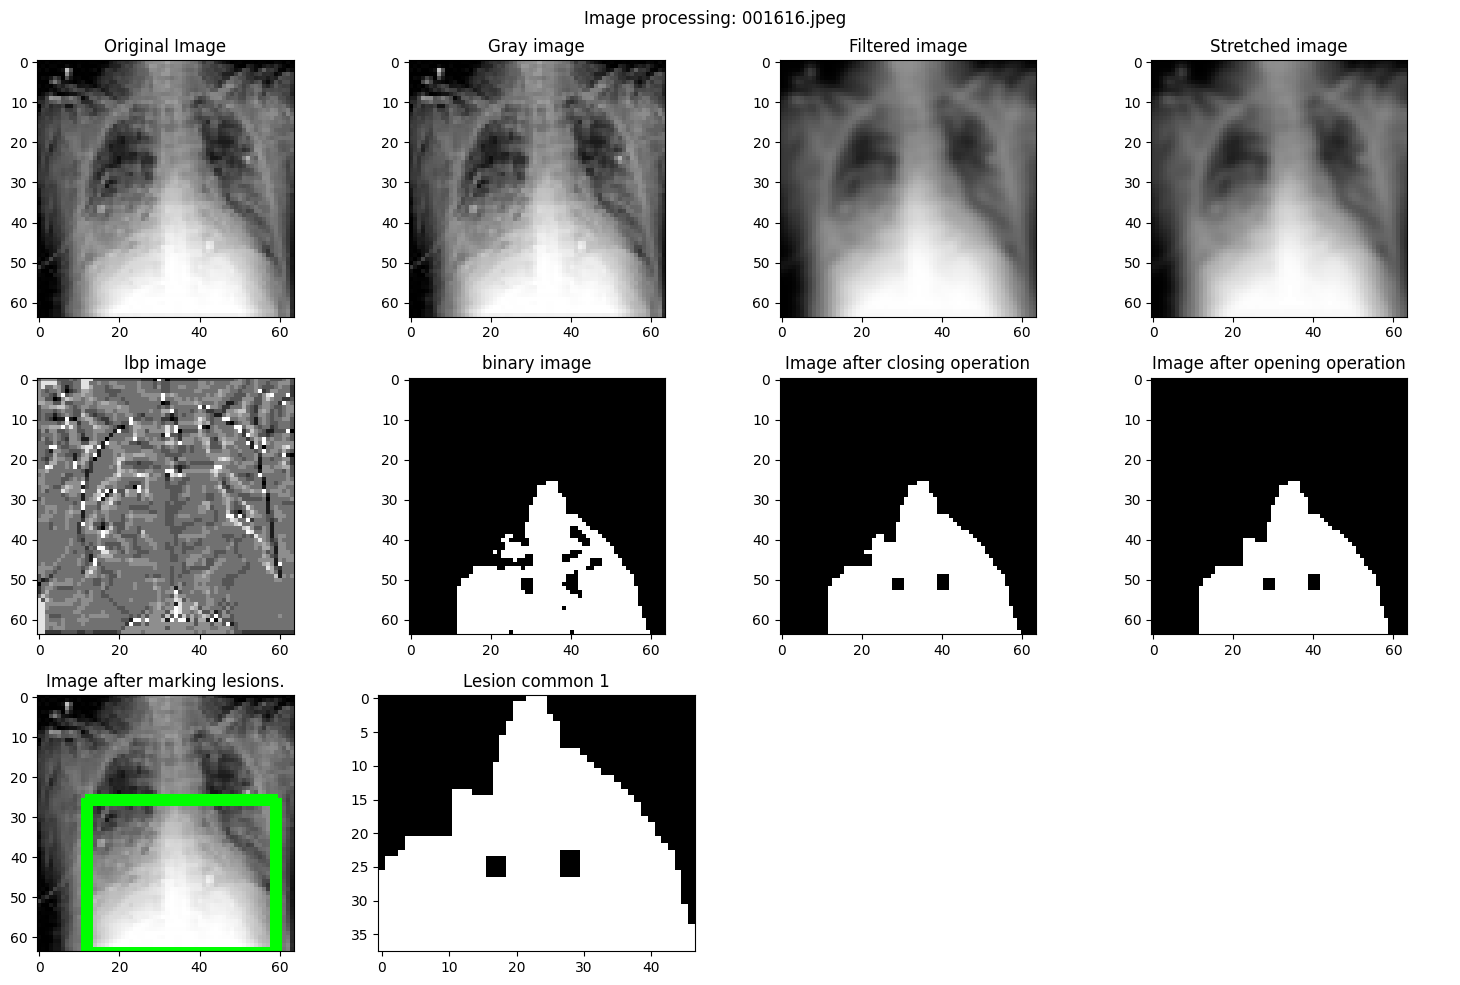

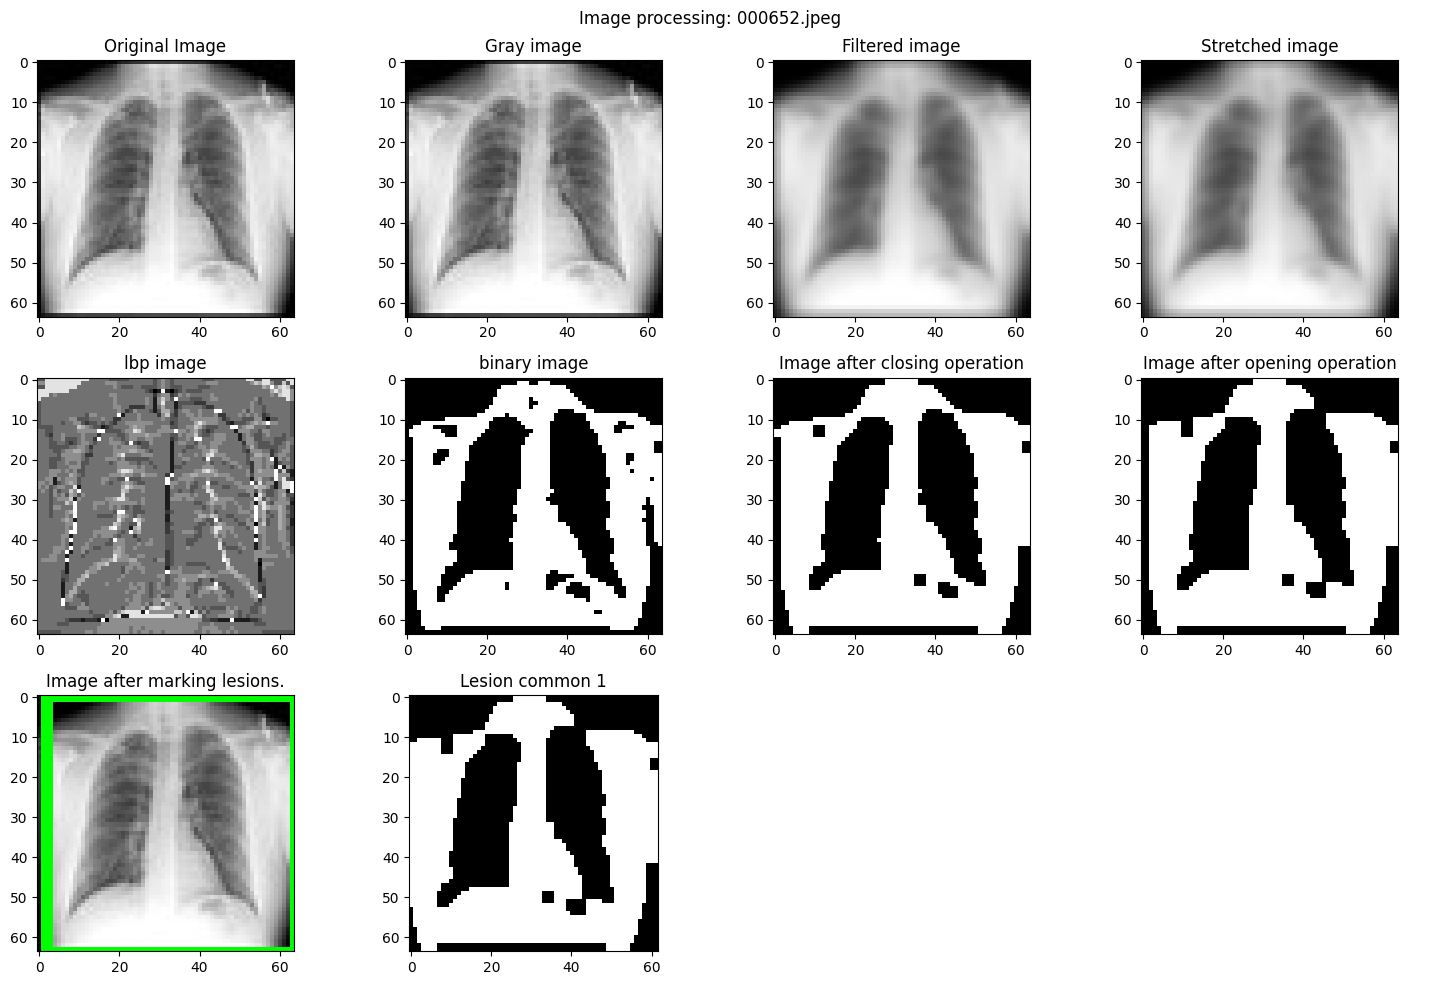

In [2]:
import cv2
from skimage.feature import local_binary_pattern
import numpy as np
import matplotlib.pyplot as plt
import os

# load image from dataset as input
def read_image(file_path):
    return cv2.imread(file_path)

# convert color image to gray, just for sample 
def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# gaussian filtering to lower interfere
def gaussian_filtering(gray_image):
    return cv2.GaussianBlur(gray_image, (5, 5), 0)

# Perform histogram stretching on the image to enhance contrast.
def histogram_stretching(gray_image):
    
    min_value = np.min(gray_image)
    max_value = np.max(gray_image)
    stretched = (gray_image - min_value) / (max_value - min_value) * 255
    return stretched.astype(np.uint8)

# 提取LBP纹理特征
def extract_lbp(gray):
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    return lbp

# Combining Otsu and adaptive threshold processing
def combined_thresholding(gray_image):
    """
    结合Otsu阈值和自适应阈值处理，得到二值图像
    :param gray_image: 灰度图像
    :return: 二值图像
    """
    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    return cv2.bitwise_and(otsu_thresh, adaptive_thresh)

# Morphological Closure Operations on Binary Images
def morphological_closing(binary_image):
    """
    对二值图像进行形态学闭运算，填充小空洞
    :param binary_image: 二值图像
    :return: 闭运算后的二值图像
    """
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Morphological opening operation on binary images
def morphological_opening(binary_image):
    """
    对二值图像进行形态学开运算，去除小噪声
    :param binary_image: 二值图像
    :return: 开运算后的二值图像
    """
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Detection of common lesions
def lesion_detection(binary_image):
    """
    检测二值图像中的病灶，并返回病灶的边界框
    :param binary_image: 二值图像
    :return: 病灶的边界框列表
    """
    contours, _ = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lesion_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter ** 2)
        x, y, w, h = cv2.boundingRect(contour)
        compactness = area / (np.pi * ((w + h) / 4) ** 2)
        if area > 100 and circularity > 0.2 and compactness > 0.5:
            lesion_boxes.append((x, y, x + w, y + h))
    return lesion_boxes

# Detection of circular lesions
def circular_lesion_detection(gray_image):
    """
    使用霍夫圆变换检测灰度图像中的圆形病灶
    :param gray_image: 灰度图像
    :return: 圆形病灶的边界框列表
    """
    circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=10, maxRadius=50)
    circular_lesion_boxes = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            circular_lesion_boxes.append((x - r, y - r, x + r, y + r))
    return circular_lesion_boxes

# Draw a bounding box on an image
def draw_bounding_boxes(image, boxes, color=(0, 255, 0), thickness=2):
    """
    在图像上绘制指定的边界框
    :param image: 图像
    :param boxes: 边界框列表
    :param color: 边界框的颜色，默认为绿色
    :param thickness: 边界框的线宽，默认为2
    :return: 绘制了边界框的图像
    """
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image

if __name__ == "__main__":
    
    folder_path = '/kaggle/input/medical-mnist/CXR'
    image_files = os.listdir(folder_path)
    for image_file in image_files[:50]:
        #if image_files.endswith(('.png', '.jpg', '.jpeg')):   
        image_path = os.path.join(folder_path, image_file)
        original_image = read_image(image_path)

        # image processing
        gray_image = convert_to_gray(original_image)
        filtered_image = gaussian_filtering(gray_image)
        stretched_image = histogram_stretching(filtered_image)
        binary_image = combined_thresholding(stretched_image)
        # Extracting LBP Texture Features
        lbp_image = extract_lbp(stretched_image)
        closed_image = morphological_closing(binary_image)
        opened_image = morphological_opening(closed_image)

            

        # lesion detection
        regular_lesion_boxes = lesion_detection(opened_image)
        circular_lesion_boxes = circular_lesion_detection(stretched_image)

        # draw box in original image
        image_with_lesions = original_image.copy()
        image_with_lesions = draw_bounding_boxes(image_with_lesions, regular_lesion_boxes, color=(0, 255, 0))
        image_with_lesions = draw_bounding_boxes(image_with_lesions, circular_lesion_boxes, color=(255, 0, 0))

        # calulate numbers of sub image be created 
        num_regular_lesions = len(regular_lesion_boxes)
        num_circular_lesions = len(circular_lesion_boxes)
        total_subplots = 9 + num_regular_lesions + num_circular_lesions

        # visualization setup 
        fig, axes = plt.subplots(3, max(4, total_subplots // 3 + (total_subplots % 3 > 0)), figsize=(15, 10))
        axes = axes.flatten()

        # visualization all image post image processing
        axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[1].imshow(gray_image, cmap='gray')
        axes[1].set_title('Gray image')
        axes[2].imshow(filtered_image, cmap='gray')
        axes[2].set_title('Filtered image')
        axes[3].imshow(stretched_image, cmap='gray')
        axes[3].set_title('Stretched image')
        axes[4].imshow(lbp_image, cmap='gray')
        axes[4].set_title('lbp image')
        
        axes[5].imshow(binary_image, cmap='gray')
        axes[5].set_title('binary image')
        axes[6].imshow(closed_image, cmap='gray')
        axes[6].set_title('Image after closing operation')
        axes[7].imshow(opened_image, cmap='gray')
        axes[7].set_title('Image after opening operation')
        axes[8].imshow(cv2.cvtColor(image_with_lesions, cv2.COLOR_BGR2RGB))
        axes[8].set_title('Image after marking lesions.')

        # show common lesion
        for i, (x1, y1, x2, y2) in enumerate(regular_lesion_boxes):
            lesion = opened_image[y1:y2, x1:x2]
            axes[9 + i].imshow(lesion, cmap='gray')
            axes[9 + i].set_title(f'Lesion common {i + 1}')

        #  show circuiar lesion
        for i, (x1, y1, x2, y2) in enumerate(circular_lesion_boxes):
            circular_lesion = stretched_image[y1:y2, x1:x2]
            axes[9 + num_regular_lesions + i].imshow(circular_lesion, cmap='gray')
            axes[9 + num_regular_lesions + i].set_title(f'Lesion circuiar {i + 1}')

        # hide sub image
        for ax in axes[total_subplots:]:
            ax.axis('off')

        plt.suptitle(f'Image processing: {image_file}')
        plt.tight_layout()
        plt.show()
    